# Ultra-High-Density Recording Explorer

- Reads in an h5 file from Lead Labs Willow System (or anything that saves data as h5 files)
- Interprets the probe map and assigns impedance data to individual sites on the probe
- Displays selected channels (16) at a time for exploring the traces individually
- Saves selected regions and plots them at publication quality
- Filters the data between 400 and 9500 Hz (in vivo recordings)

## User Input

In [1]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
#datafile = '20200324-surface.h5' # Data File
datafile = '20200324-third.h5'
impfile = 'impedance_20200324-122009.h5' # Impedance File

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time

## Read in impedence data

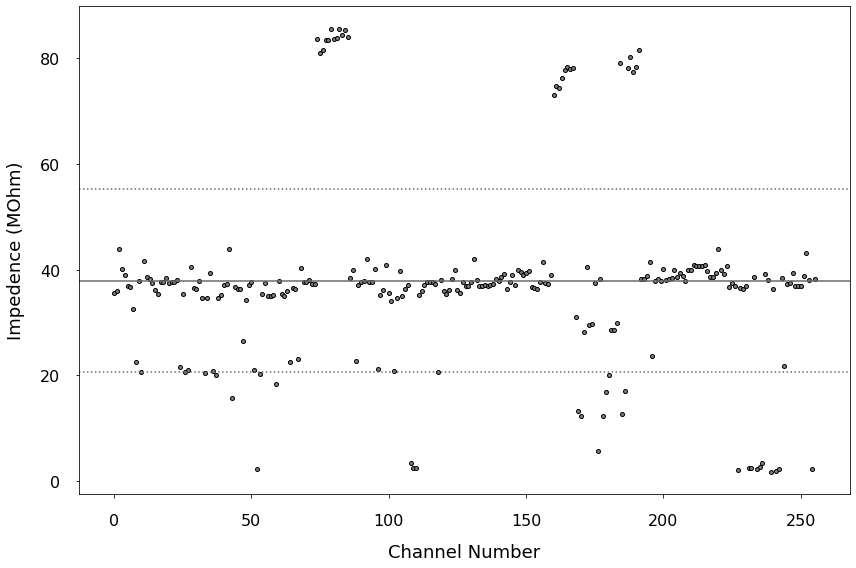

In [3]:
f_imp = h5py.File(impfile, 'r')

def get_impedence(f_imp):
    fig, ax = plt.subplots(figsize = (12,8))
    imp = f_imp['impedanceMeasurements'][:]
    x = np.where (imp > 0)[0]
    y = [imp[i] / 100000 for i in x] 
    ax.plot(x, y, ls = 'none', markersize = 4, marker = 'o', color = 'gray', mec = 'black')  
    ax.set_ylabel ('Impedence (MOhm)', fontsize = 18, labelpad = 15)
    ax.set_xlabel ('Channel Number', fontsize = 18, labelpad = 15)
    plt.tick_params(axis = 'both', which = 'major', pad = 15, labelsize = 16)
    init_avg = np.mean(y)
    init_sd = np.std(y)
    high = np.where(y > np.mean(y) + 2 * np.std(y))[0]
    low = np.where (y < np.mean(y)- 2 * np.std(y))[0]
    adj_y = [y1 for y1 in y if y1 not in low]
    adj_y = [y1 for y1 in y if y1 not in high]
    adj_high = np.where(y > np.mean(adj_y) + 2 * np.std(adj_y))[0]
    adj_low = np.where (y < np.mean(adj_y)- 2 * np.std(adj_y))[0]
    
    report = {'avg': np.mean(adj_y),
          'std': np.std(adj_y),
          'high': adj_high,
          'low' : adj_low}    
    
    display(HTML("<br><hr><h4>Mean impedence = <font color = 'red'>" + str(round(report['avg'],3)) + 
                 "</font><br><br> Standard Deviation =  <font color = 'red'>" + str(round(report['std'],3)) 
                 + '</font><br><br>' 
                 + "Channels with High Resistance (greater than 2 std above the mean) =  <font color = 'red'><br><br>"  
                 + str(report['high']).replace('[','').replace(']', '') + "</font><br><br>" +
                 "Channels with Low Resistance (less than 2 std below the mean) = <font color = 'red'><br><br>" +
                str(report['low']).replace('[','').replace(']', '') + "</font>" + " <br><hr color = 'gray'><br>"))
    
    ax.axhline(report['avg'], color = 'dimgray')
    ax.axhline(report['avg'] + report['std'], ls = ":", color = 'dimgray')
    ax.axhline(report['avg'] - report['std'], ls = ":", color = 'dimgray')

    plt.tight_layout()
    
    return report, x, y
    
imp_report, channels, imp = get_impedence (f_imp)


#    print(f_imp['impedanceMeasurements'][0])




## Read in the Multichannel Data

In [4]:
f_data = h5py.File(datafile, 'r')

# Pull data from h5 into variables
si = f_data.get('sample_index') # channel # (x)
ys = f_data.get('channel_data') # actual data in microvolts (y)
ys = ys[:, channels] # Remove unconnected channels (based on impedence data)

display (HTML("<br><hr><h4>Data consists of <font color = 'red'>" + str(ys.shape[1]) + 
              "</font> columns of data (channels, x) and <font color = 'red'>" + str(ys.shape[0]) + "</font> rows of data (measurements, y).<hr><br>"))

## Bandpass Filter (butterworth)

In [5]:
from scipy.signal import butter, sosfiltfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

fs = 30000.0
lowcut = 400
highcut = 9500.0

y_filt = []
display (HTML("<br><hr color = 'gray'><h4>Analyzing channel: "))
for chan in channels:
    print(chan, end = ' ')
    order = 9
    x = np.arange(len(ys[:,chan]))
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sosfreqz(sos, worN=2000)
    #ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    #ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
    #ax[0].set_xlabel('Frequency (Hz)')
    #ax[0].set_ylabel('Gain')
    #ax[0].legend(loc='best')
    y_filt.append(butter_bandpass_filter(ys[:,chan], lowcut, highcut, fs, order=order))
display (HTML("<br><hr color = 'gray'><br> "))


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 

## Plot Unfiltered and Filtered Traces from Shank #1

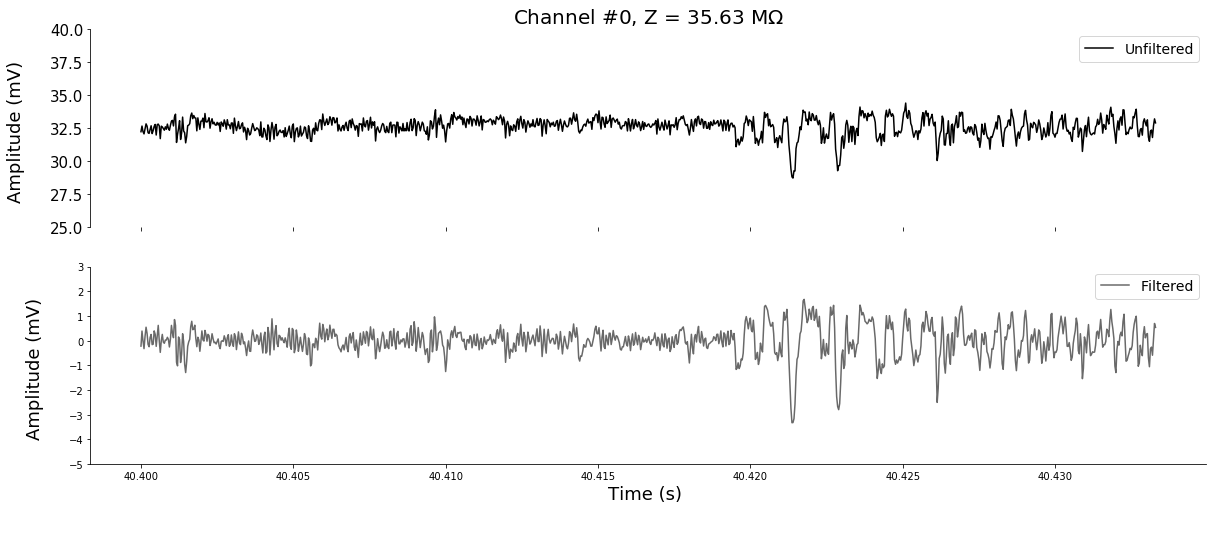

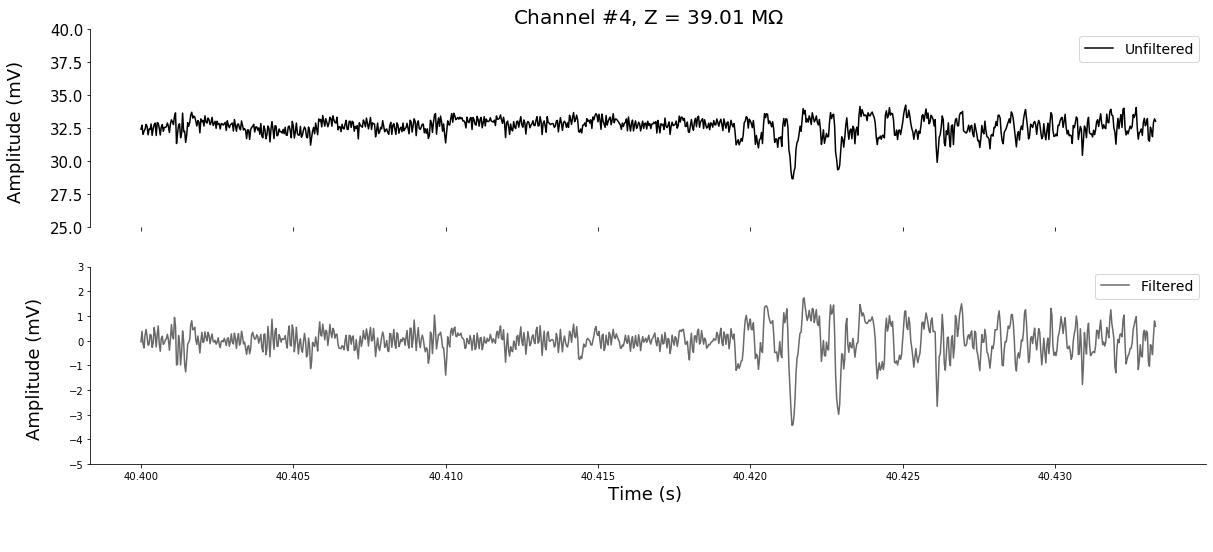

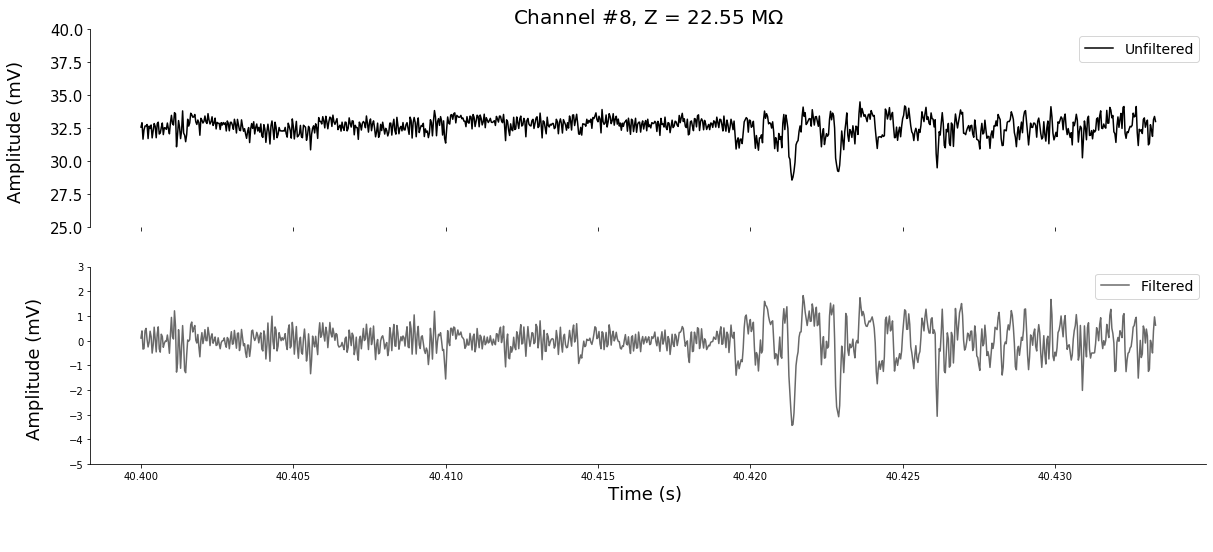

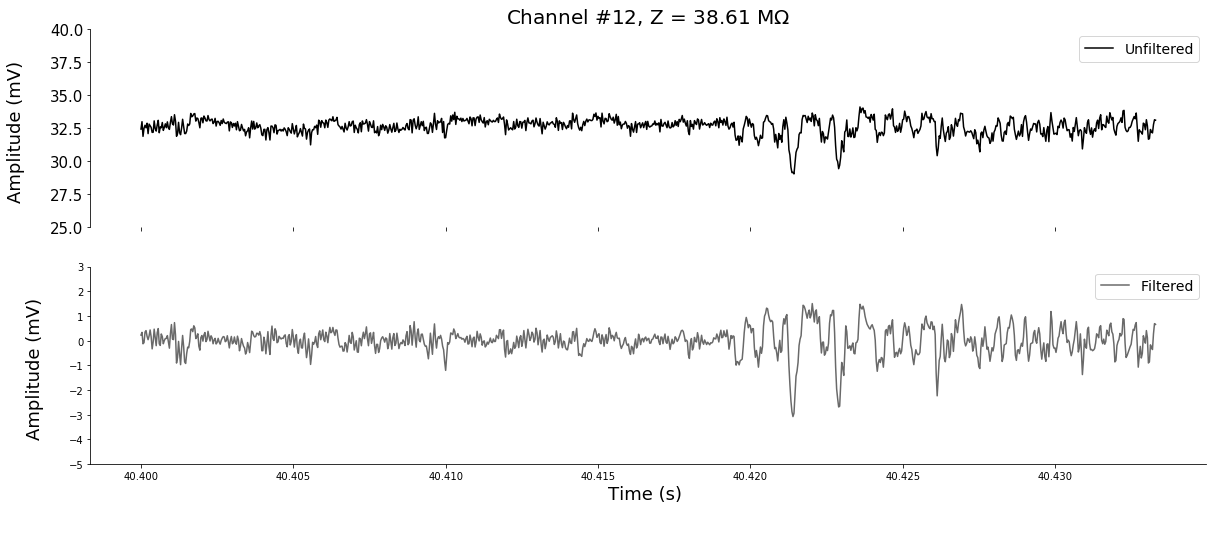

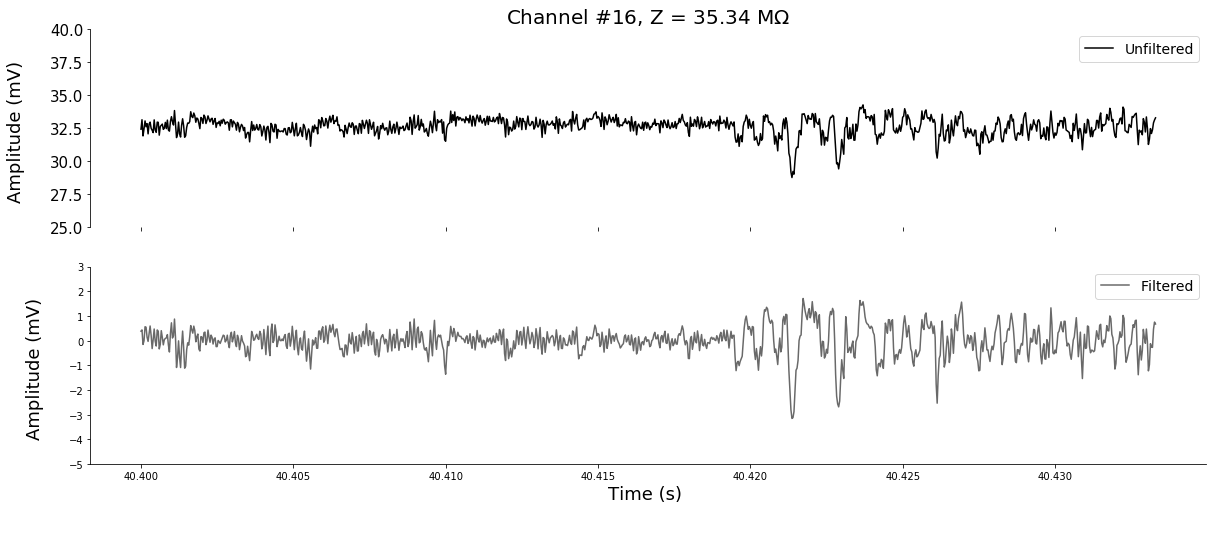

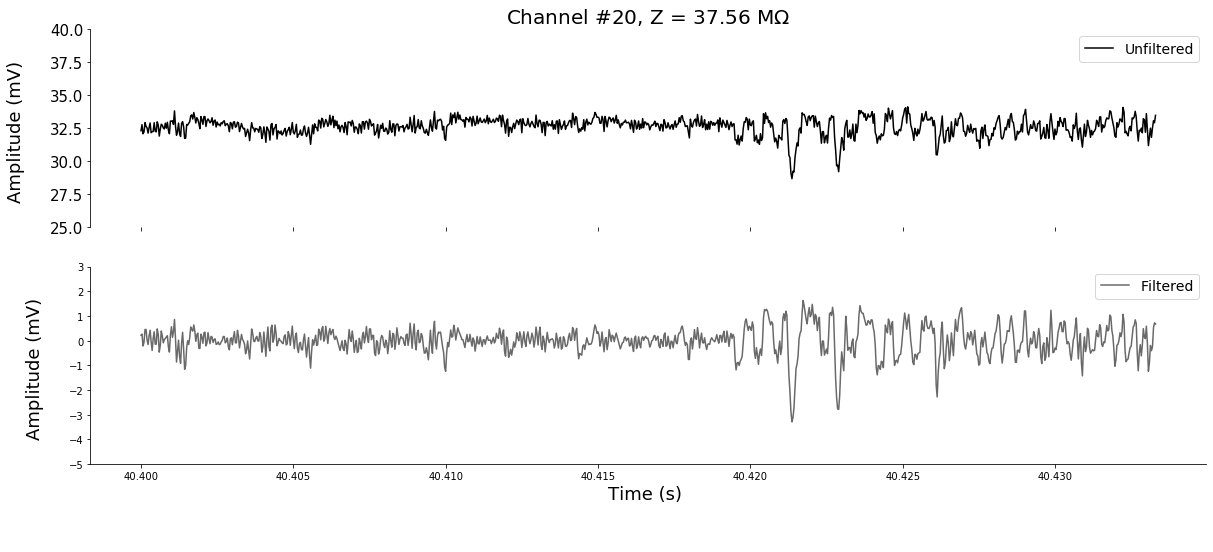

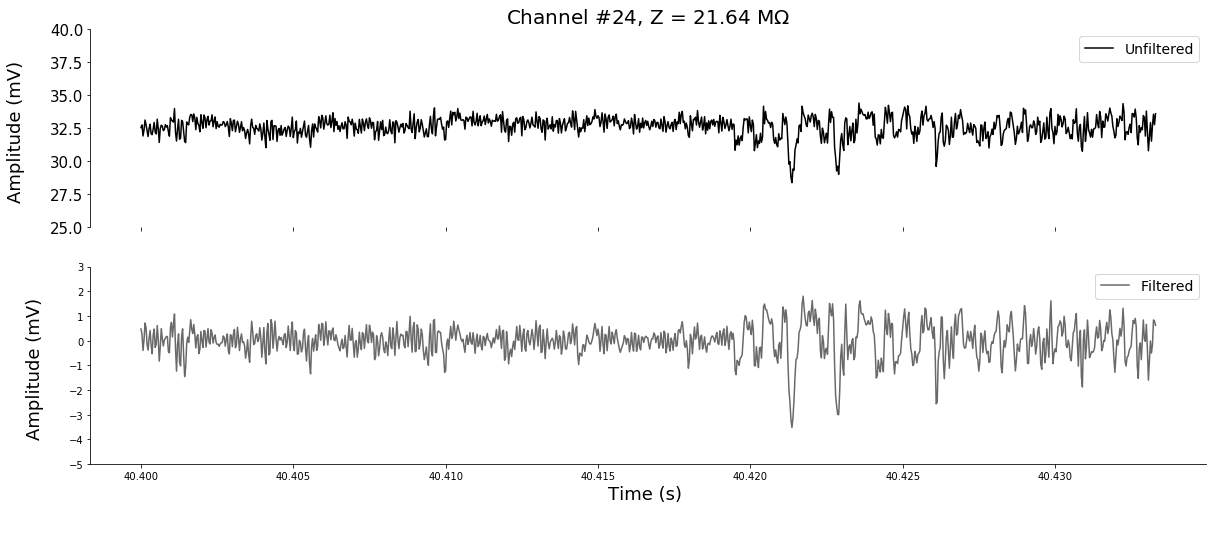

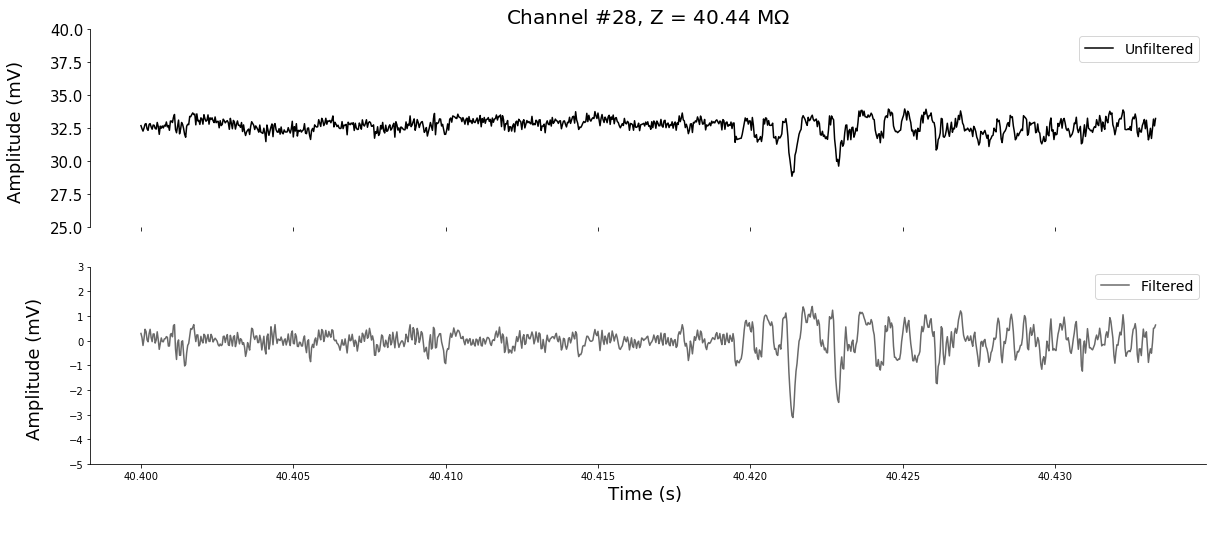

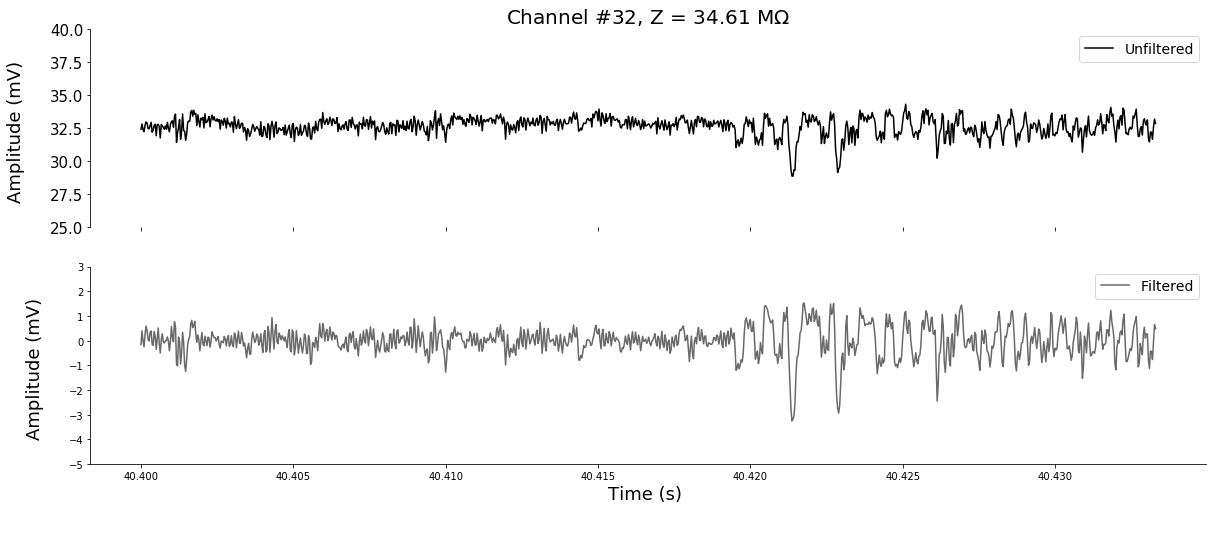

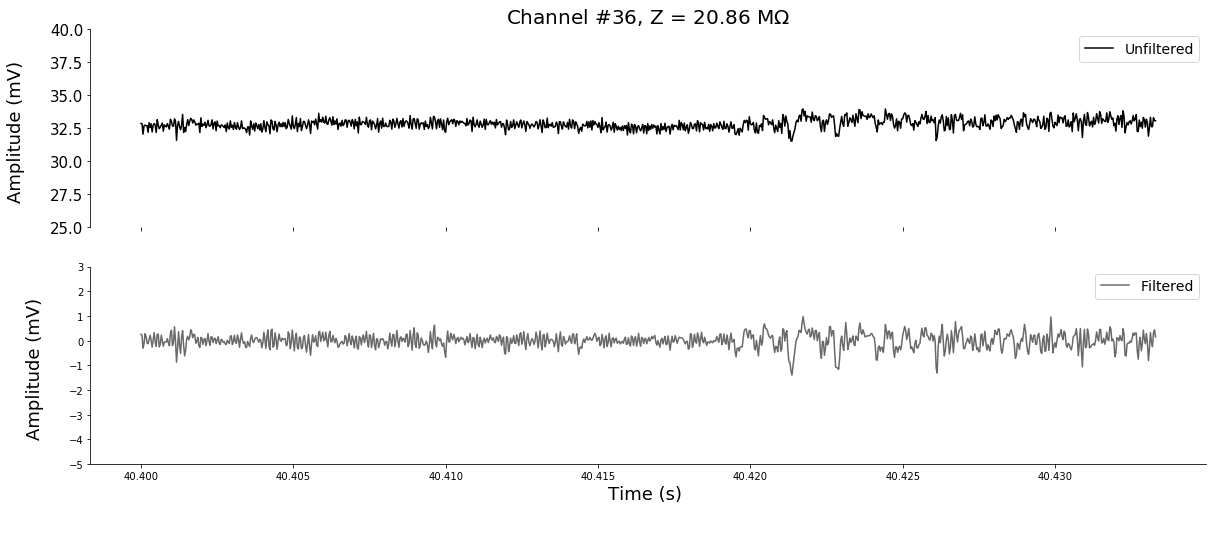

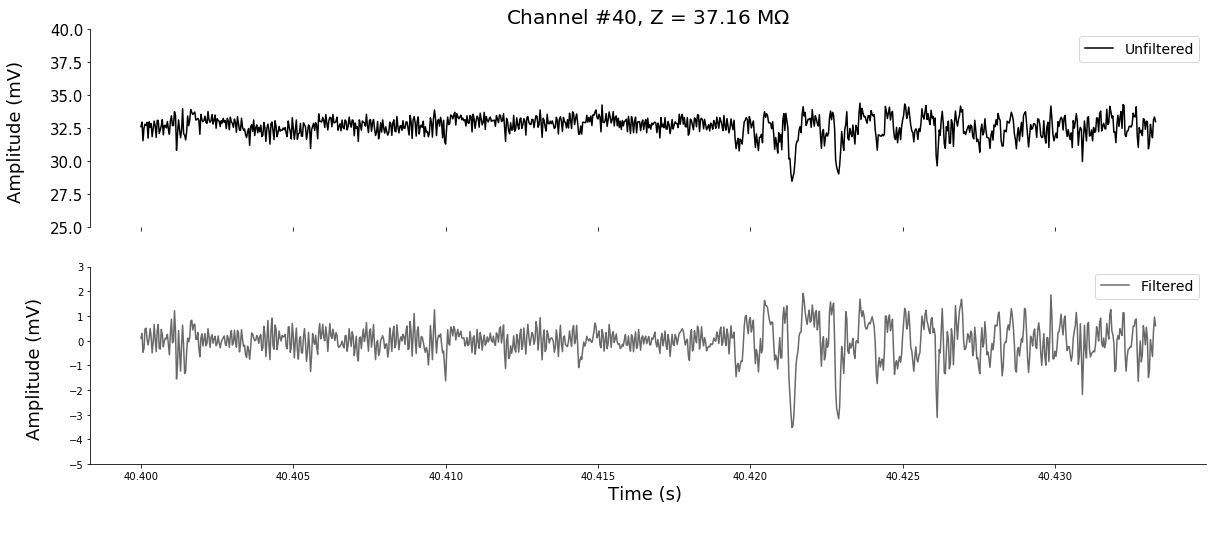

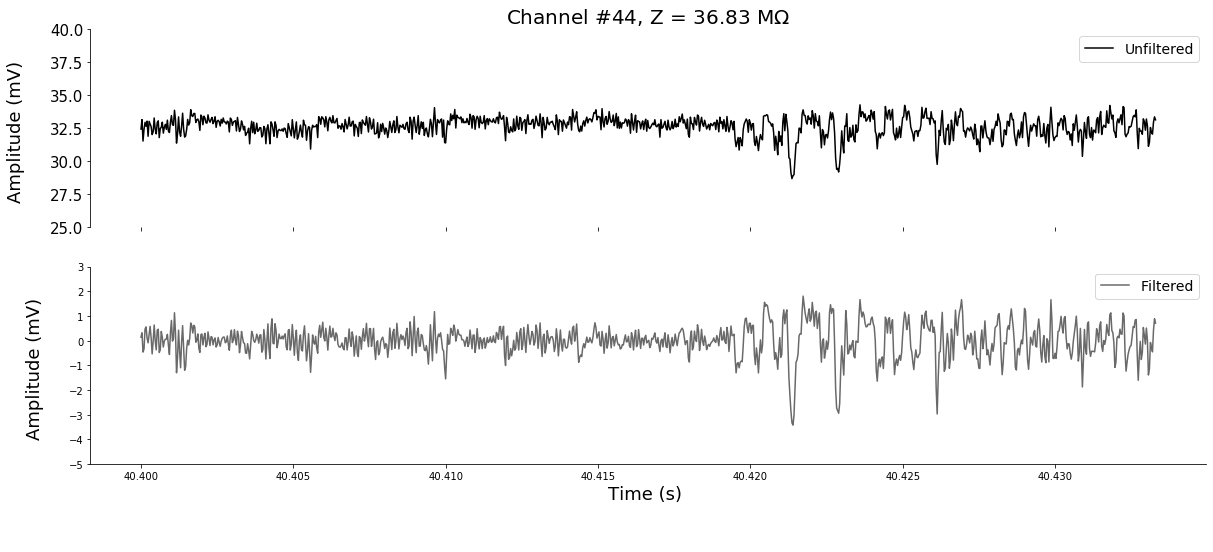

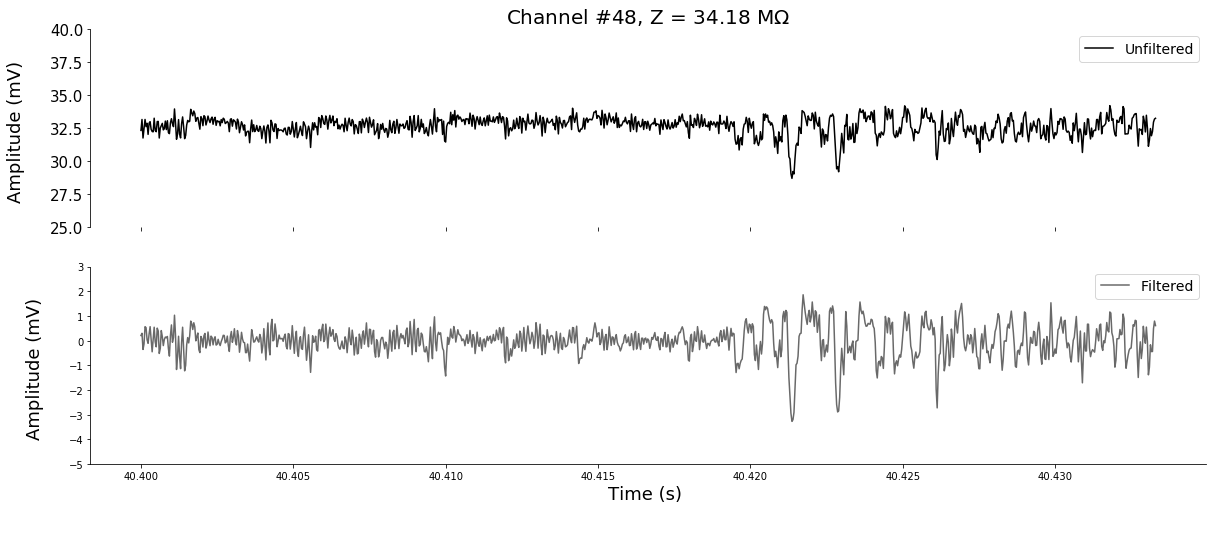

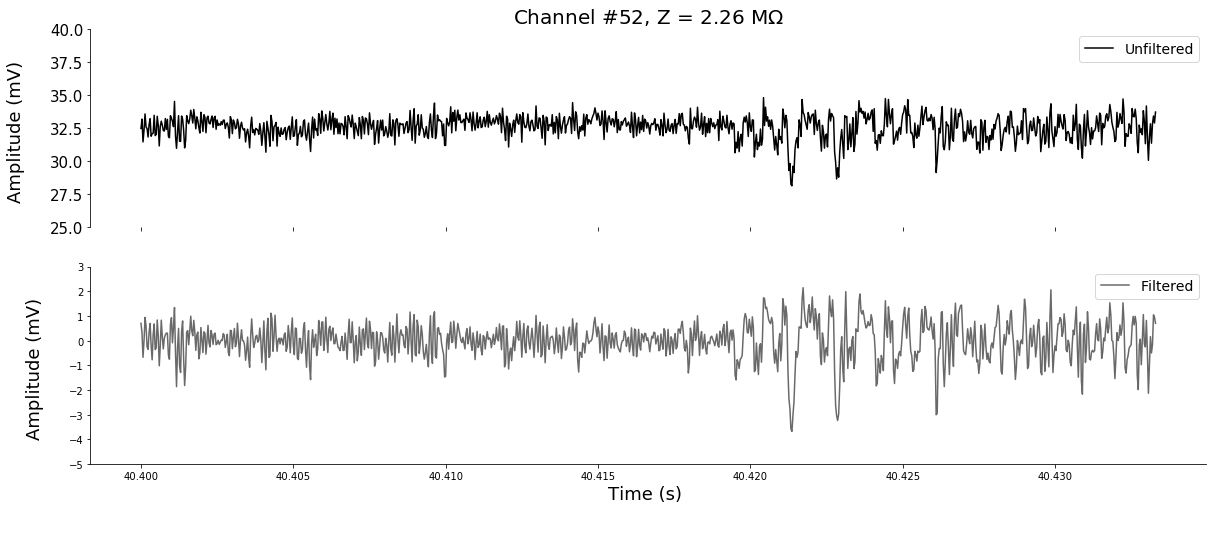

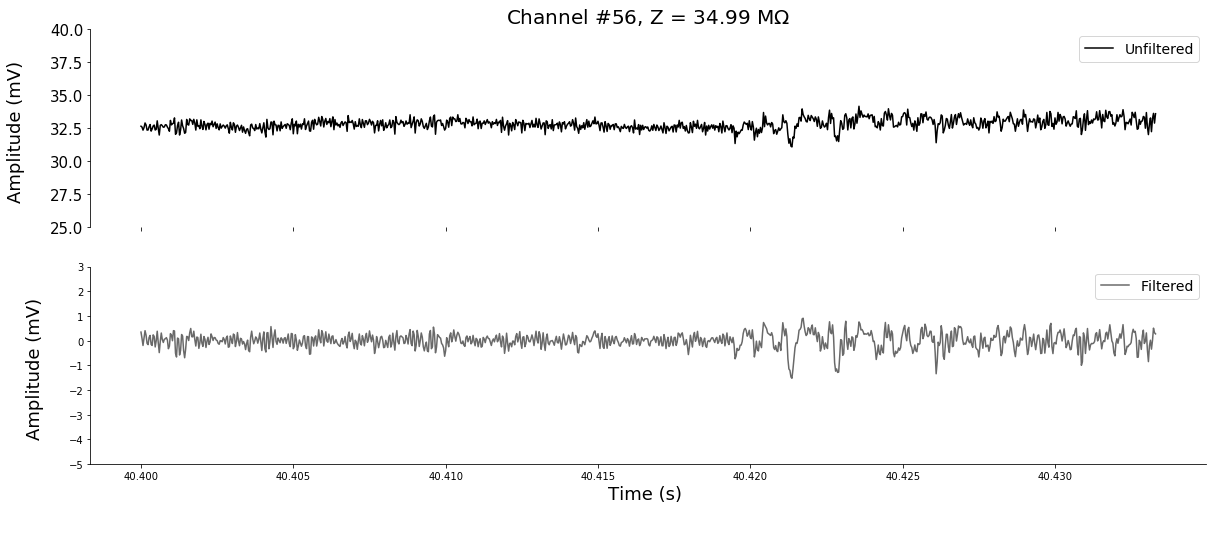

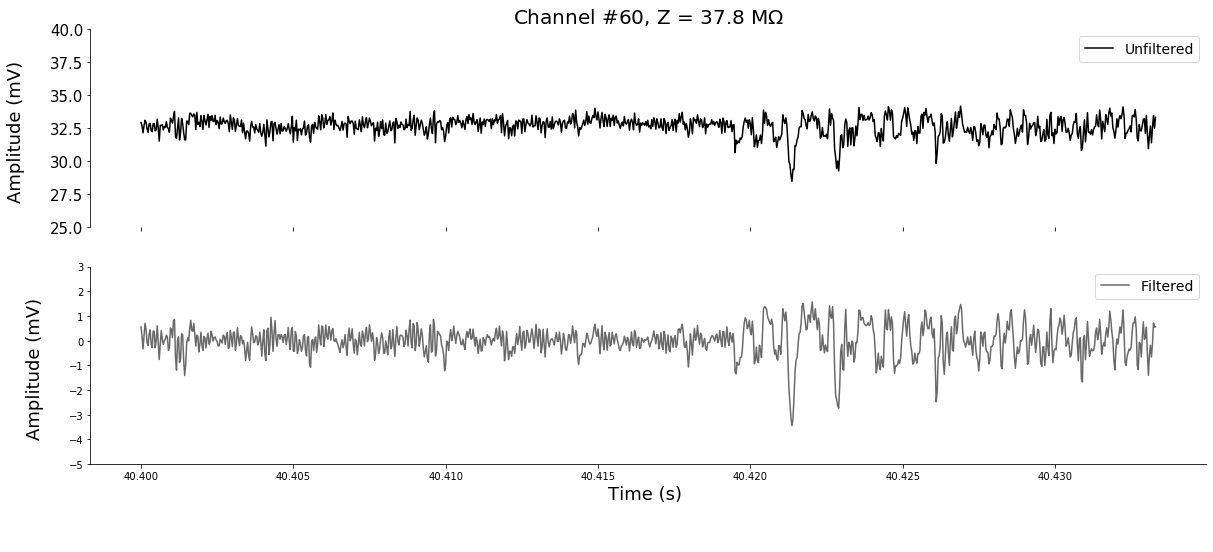

In [16]:
chans = list(np.arange(0,63,4))
start =1212000 
end = 1213000

display(HTML("<br><hr color = 'gray'><h2><br><center>Shank # 1, Plotting every 4th channel (1-64)</h2></center><br>"))
for chan in chans:
    
    fig, ax = plt.subplots (2,1, figsize = (20,8), sharex = True, frameon = True)

    ax[0].plot(x[start:end]/fs, ys[start:end, chan]/1000, color = "black", label='Unfiltered') # Unfiltered Signal
    ax[1].plot(x[start:end]/fs, y_filt[chan] [start:end]/1000, color = 'dimgray', label='Filtered') # Filtered Signal

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)

    y_lims = ax[0].get_ylim()
    ax[0].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[0].set_ylim(25, 40)
    y_lims = ax[1].get_ylim()
    #ax[1].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[1].set_ylim(-5, 3)
   
    ax[0].set_title("Channel #" + str(chan) + ', Z = ' + str(round(imp[chan],2))  + r' M$\Omega$', fontsize = 20)
    ax[1].set_xlabel('Time (s) \n \n', fontsize = 18)
    ax[0].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[1].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[0].tick_params (labelsize = 15)
    
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

plt.show()
    

## Plot Unfiltered and Filtered Traces from Shank #2

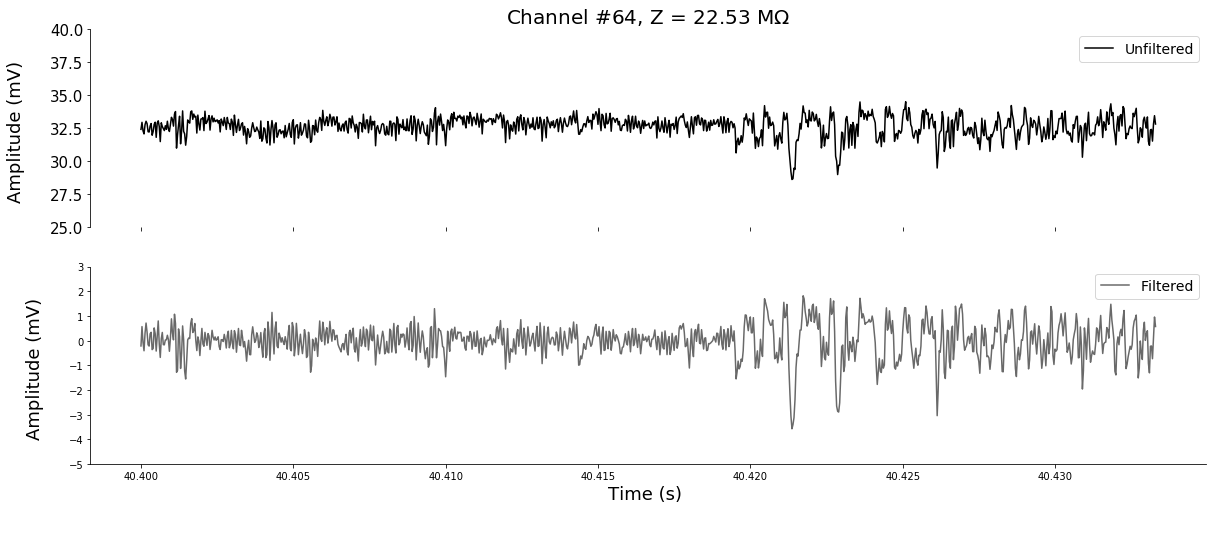

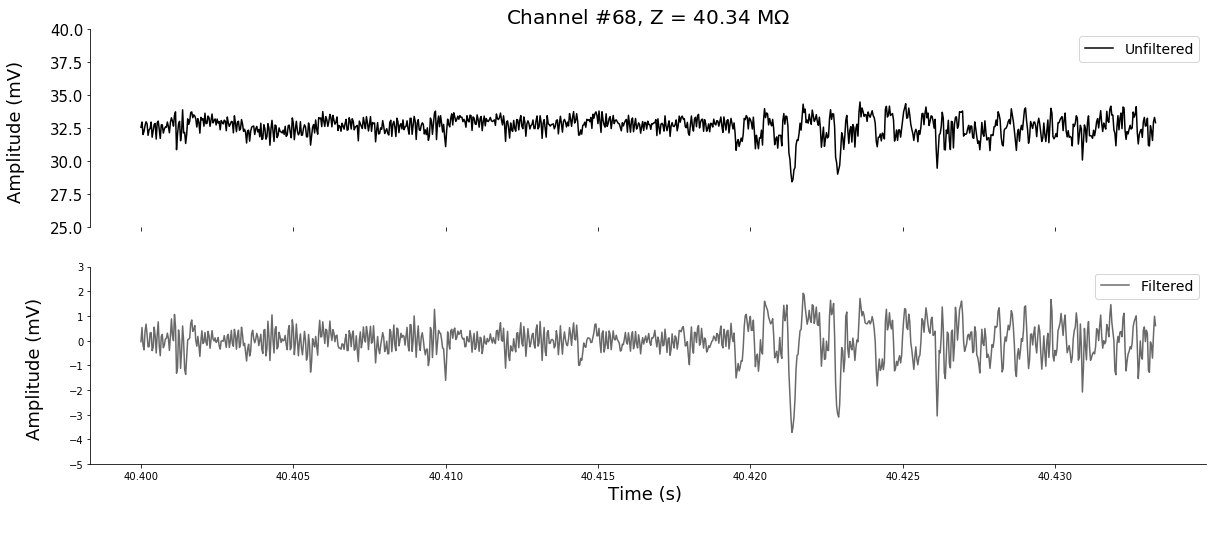

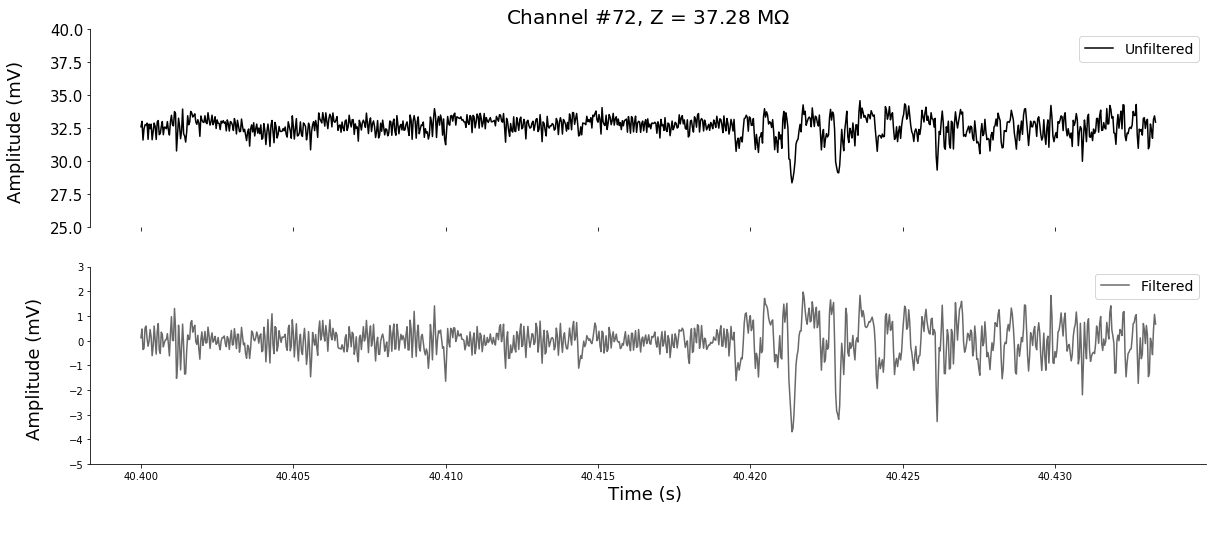

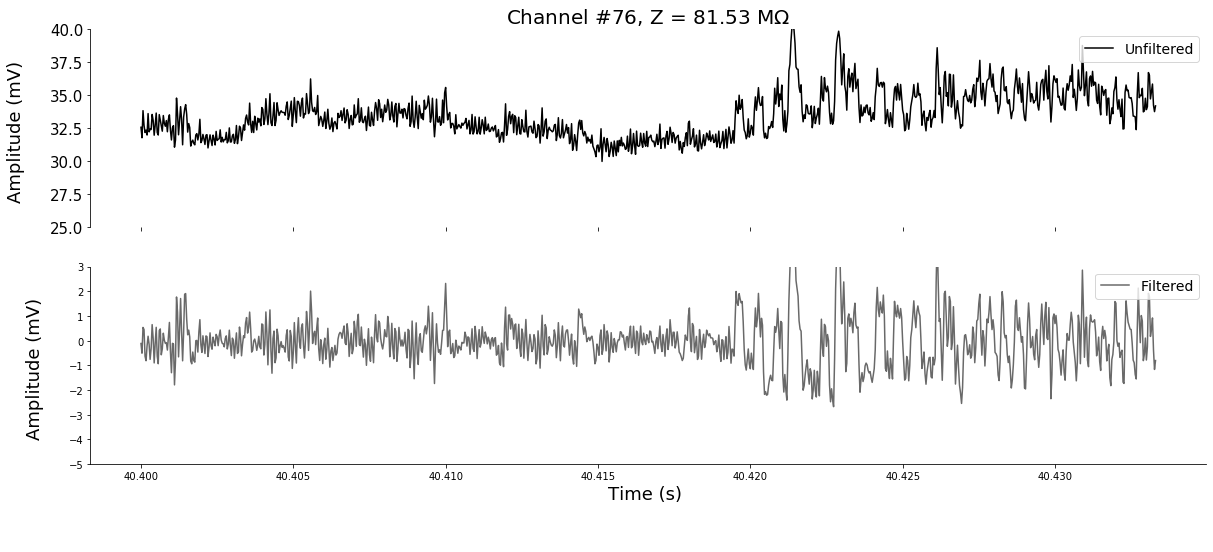

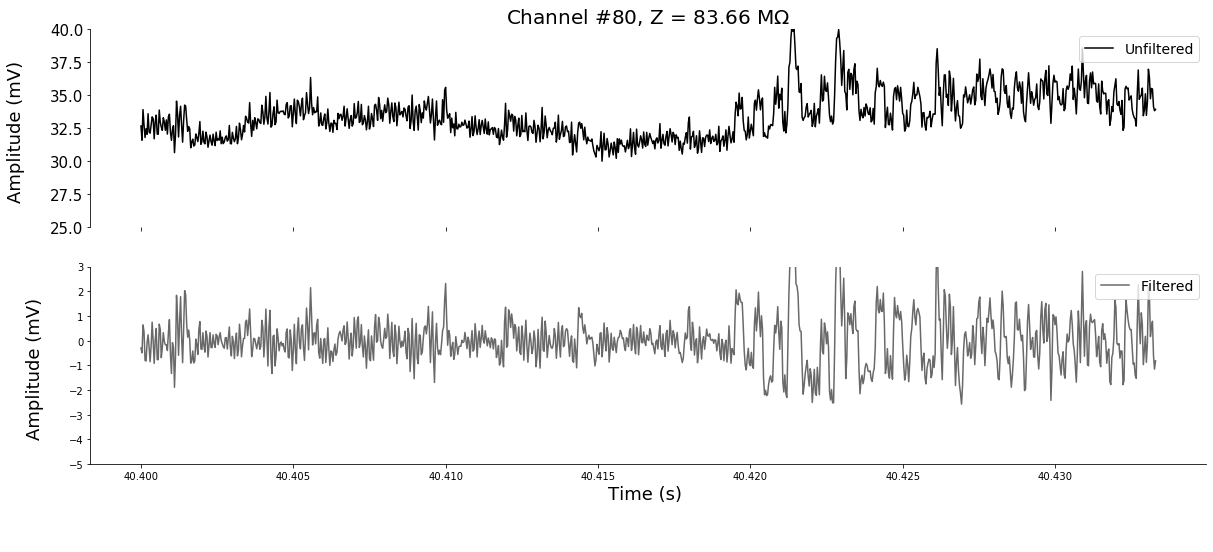

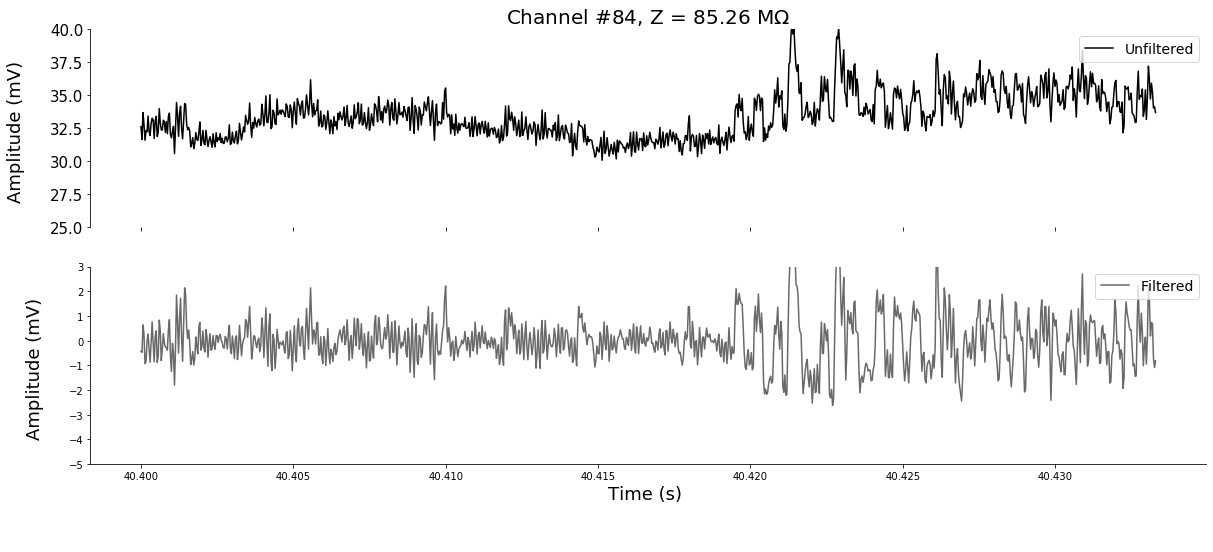

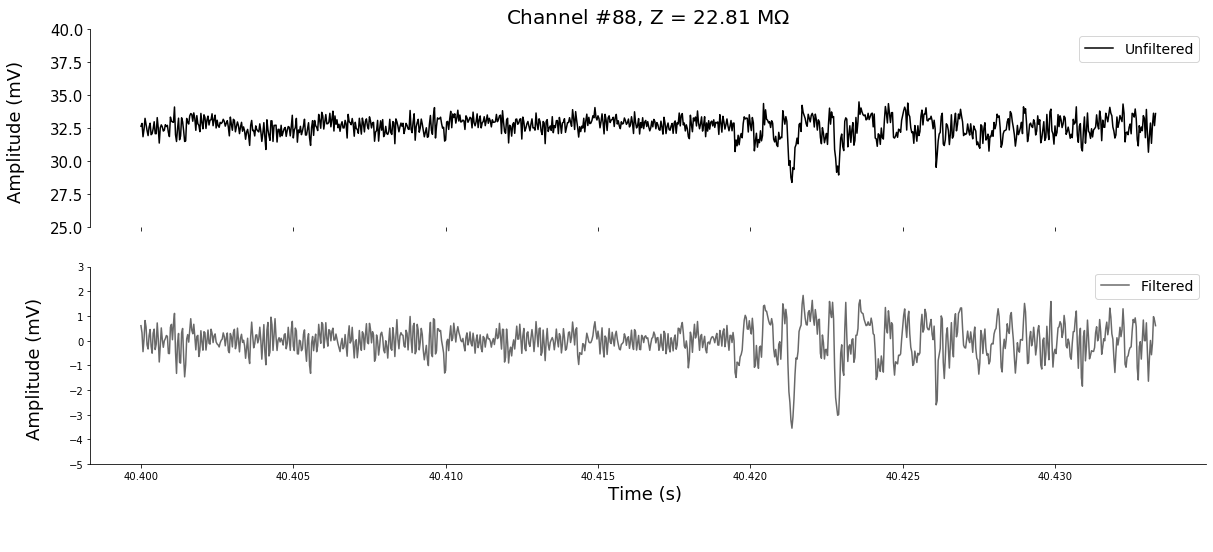

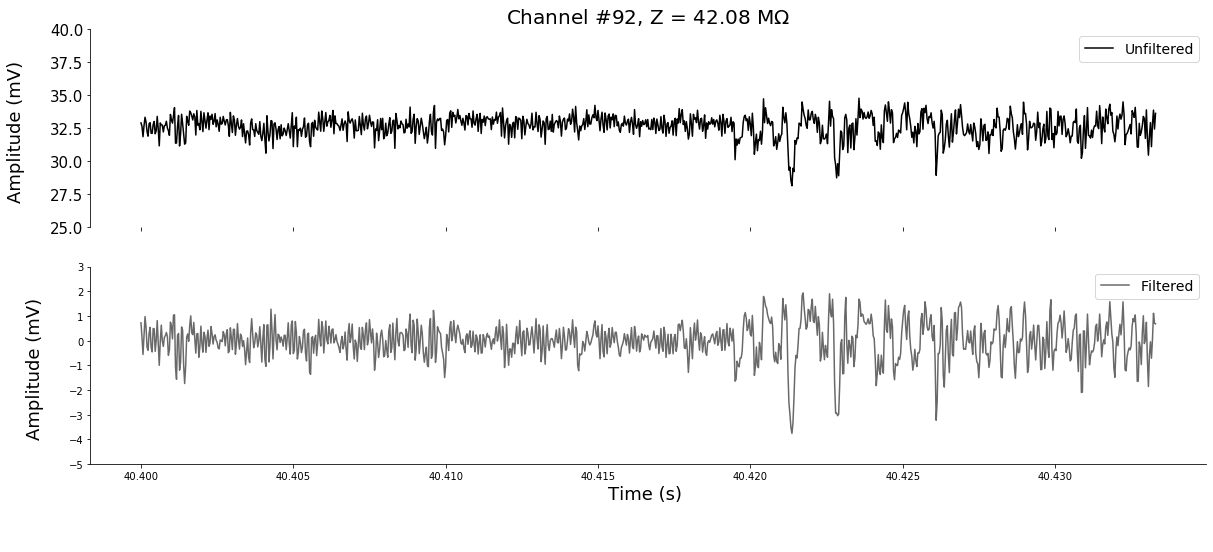

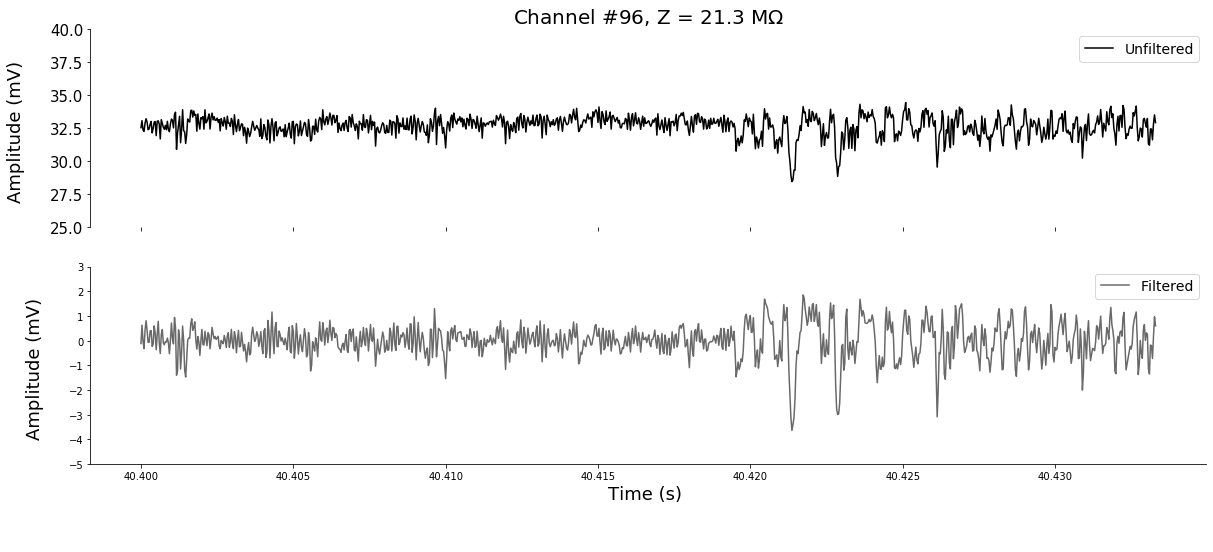

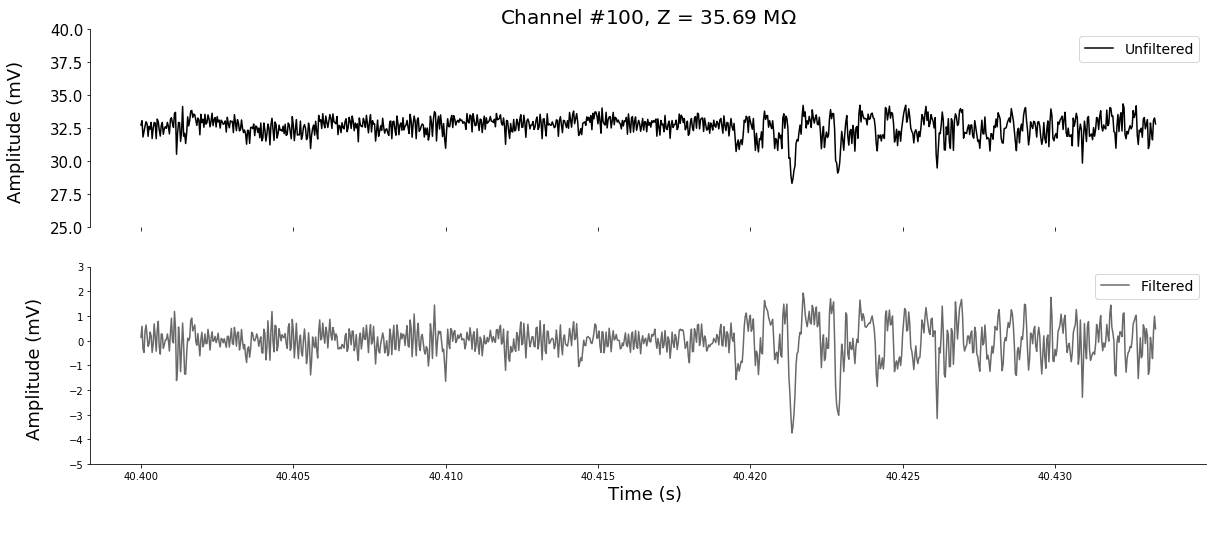

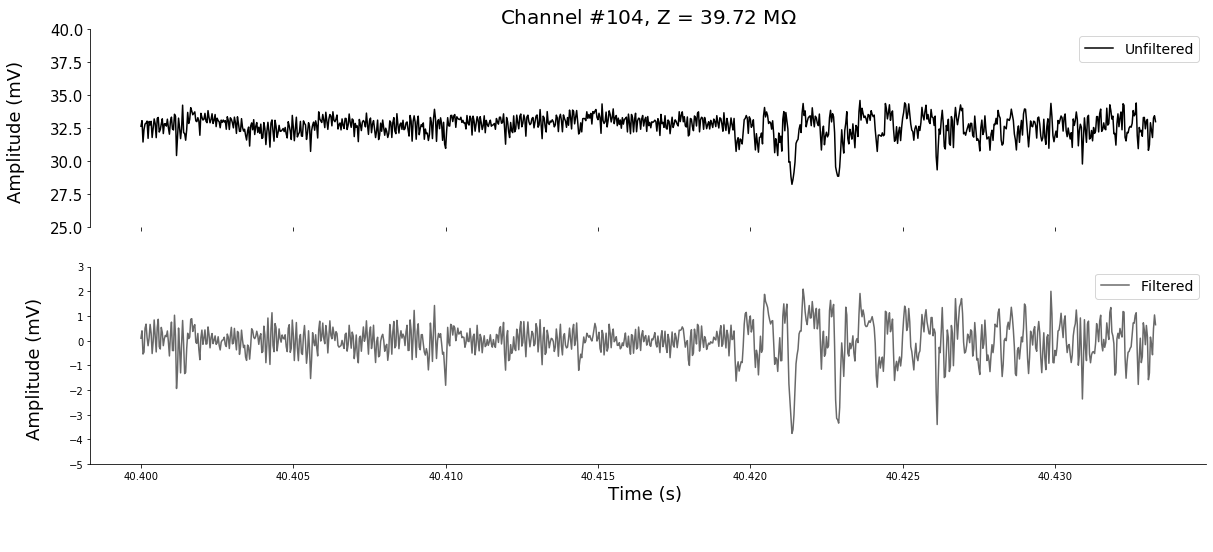

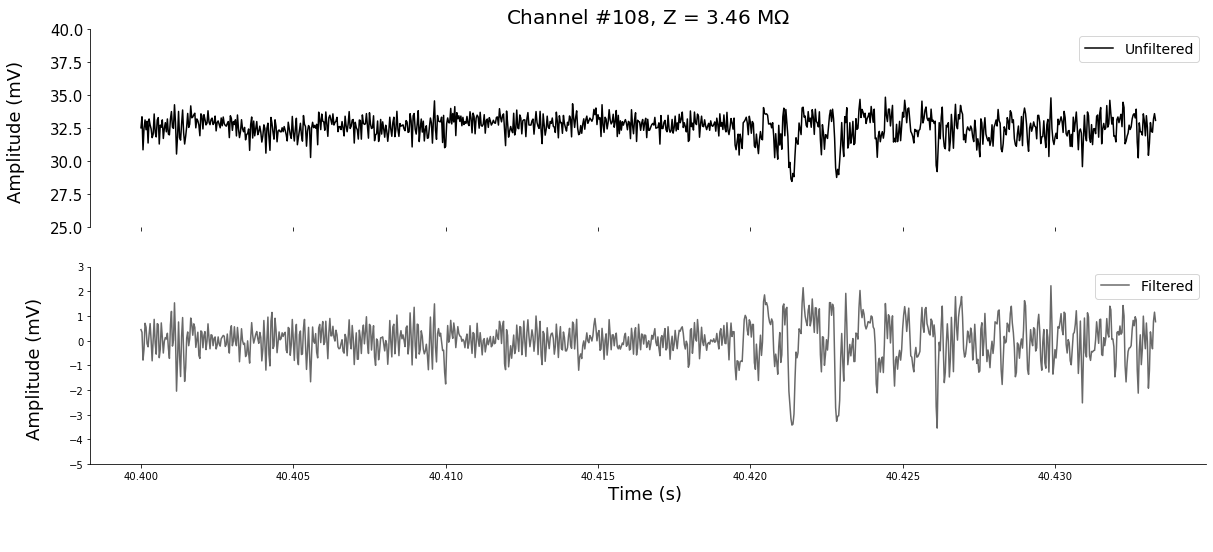

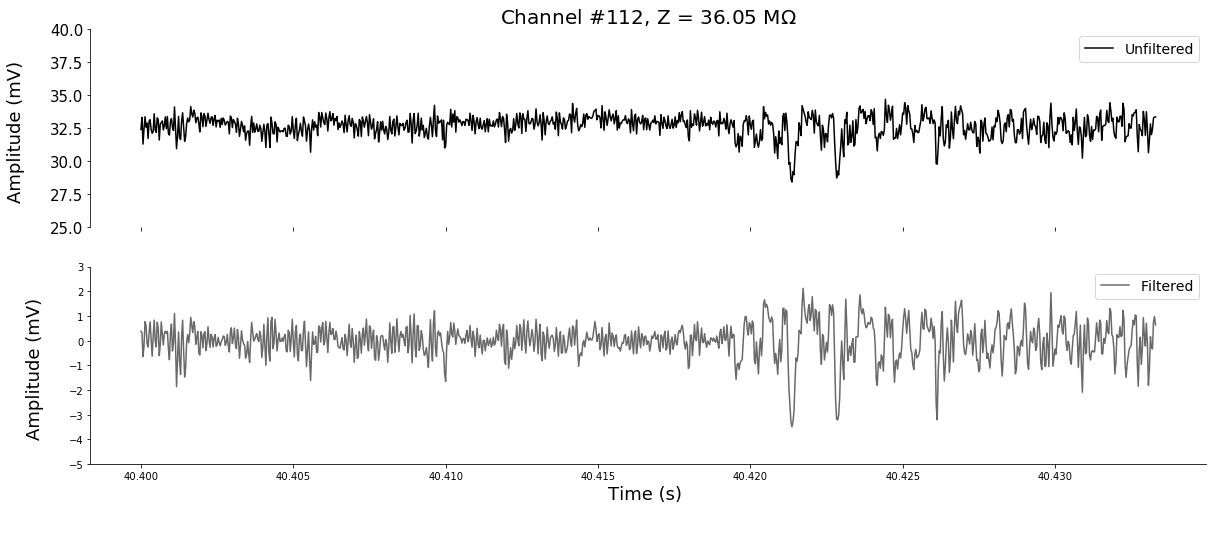

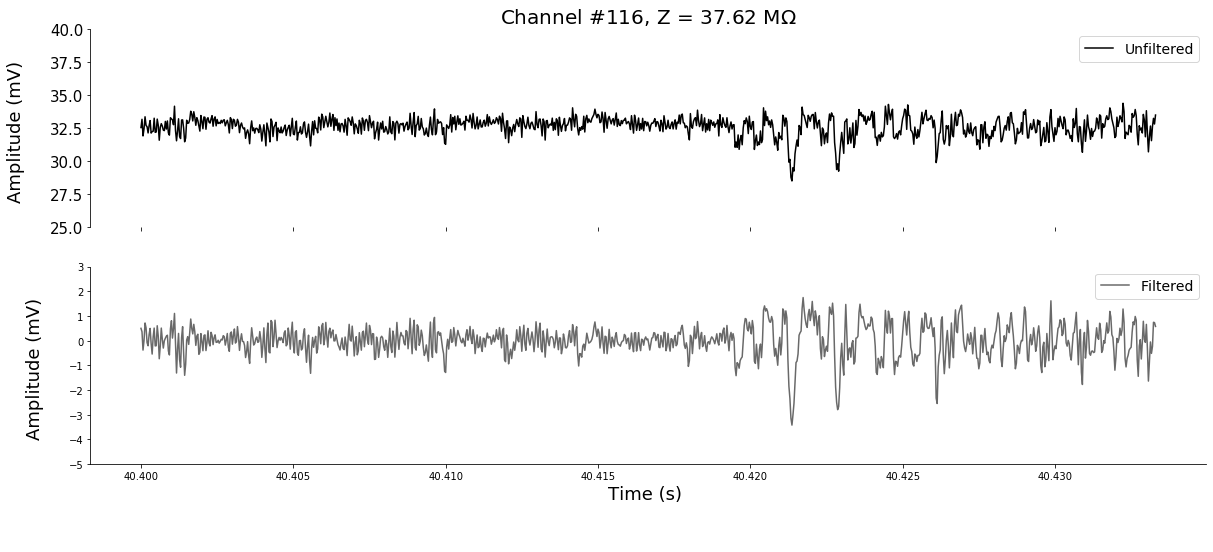

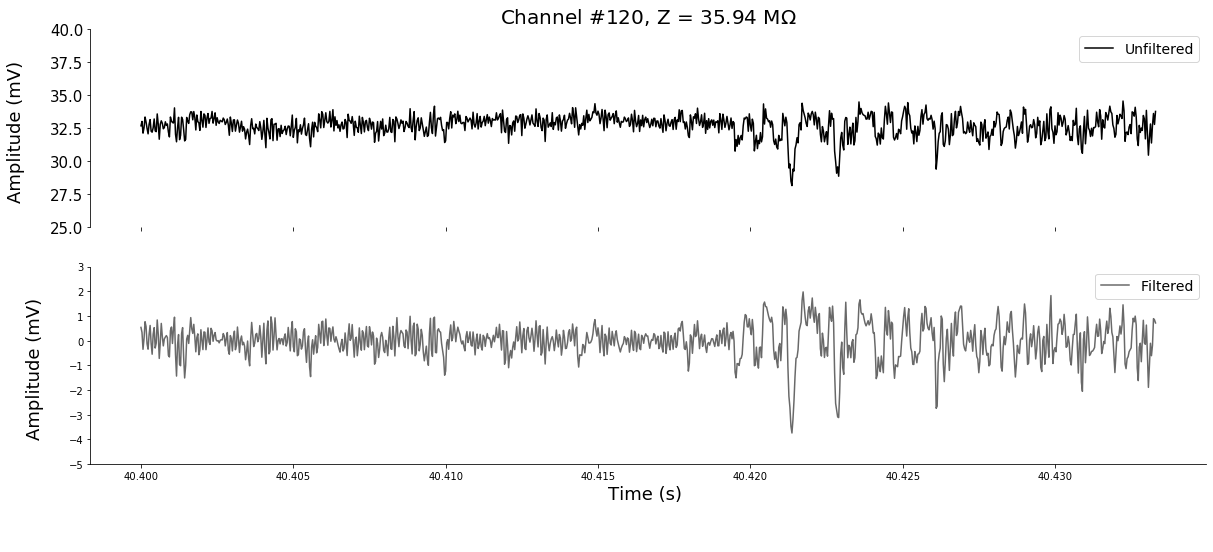

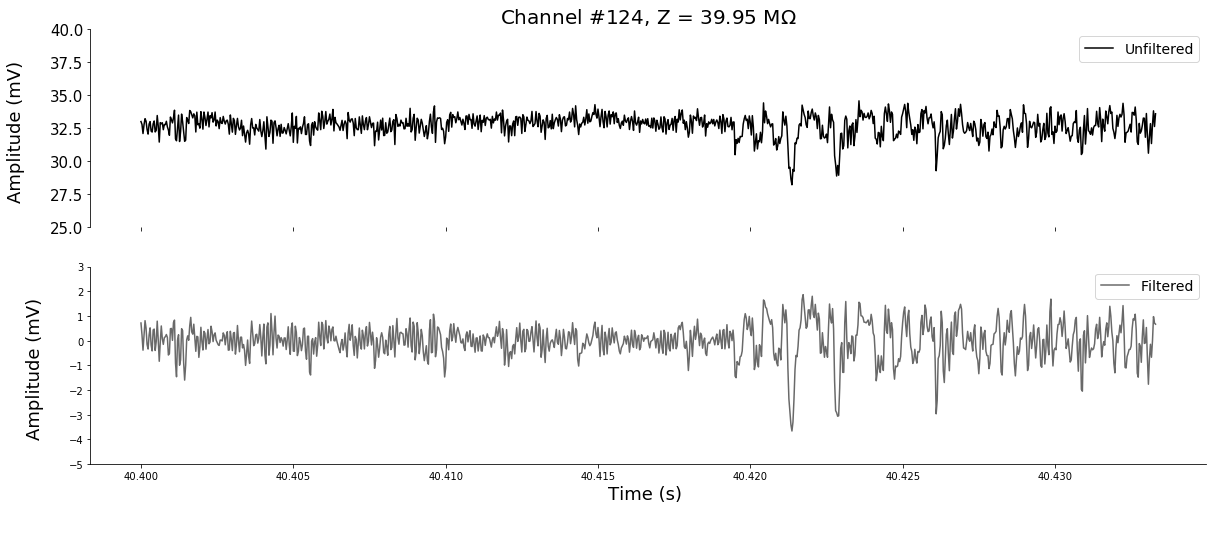

In [20]:
chans = list(np.arange(64,128,4))
start =1212000 
end = 1213000

display(HTML("<br><hr color = 'gray'><h2><br><center>Shank # 2, Plotting every 4th channel (65-128)</h2></center><br>"))
for chan in chans:
    
    fig, ax = plt.subplots (2,1, figsize = (20,8), sharex = True, frameon = True)

    ax[0].plot(x[start:end]/fs, ys[start:end, chan]/1000, color = "black", label='Unfiltered') # Unfiltered Signal
    ax[1].plot(x[start:end]/fs, y_filt[chan] [start:end]/1000, color = 'dimgray', label='Filtered') # Filtered Signal

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)

    y_lims = ax[0].get_ylim()
    ax[0].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[0].set_ylim(25, 40)
    y_lims = ax[1].get_ylim()
    #ax[1].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[1].set_ylim(-5, 3)
   
    ax[0].set_title("Channel #" + str(chan) + ', Z = ' + str(round(imp[chan],2))  + r' M$\Omega$', fontsize = 20)
    ax[1].set_xlabel('Time (s) \n \n', fontsize = 18)
    ax[0].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[1].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[0].tick_params (labelsize = 15)
    
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

plt.show()
    

## Plot Unfiltered and Filtered Traces from Shank #3

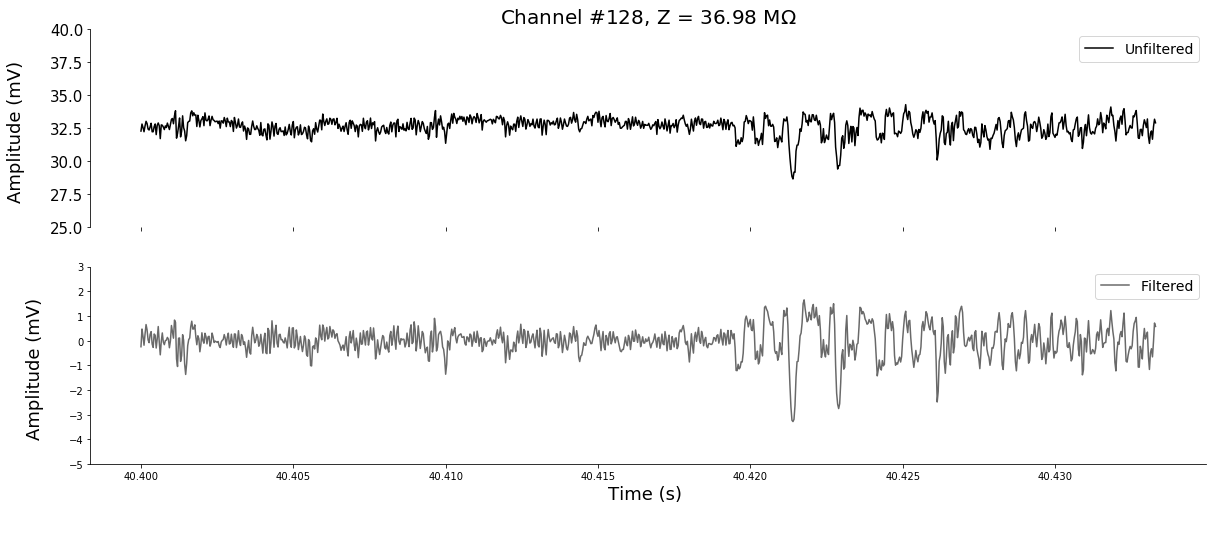

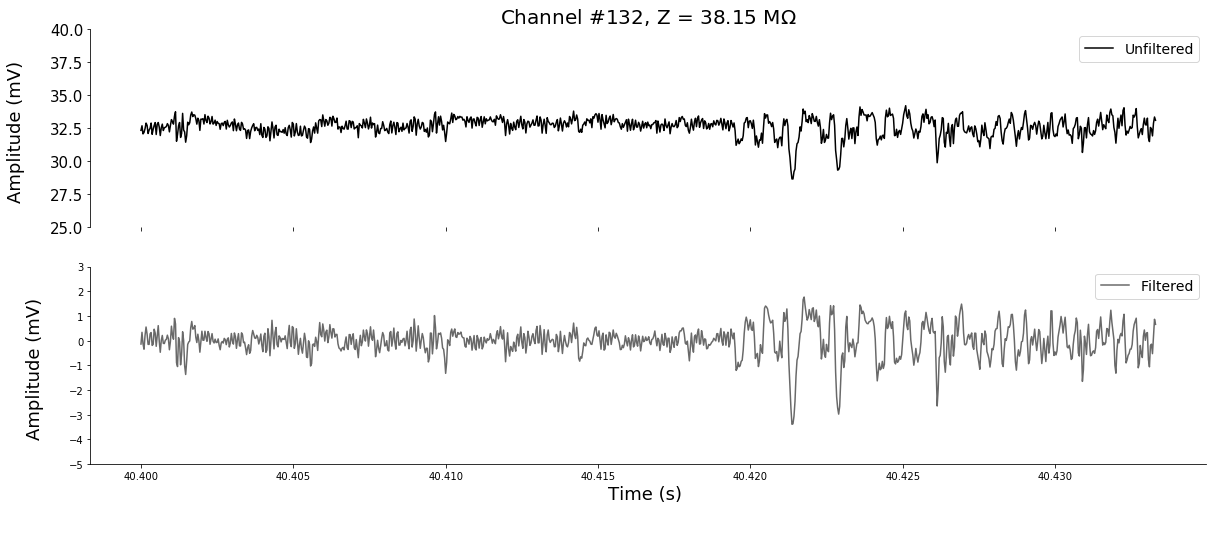

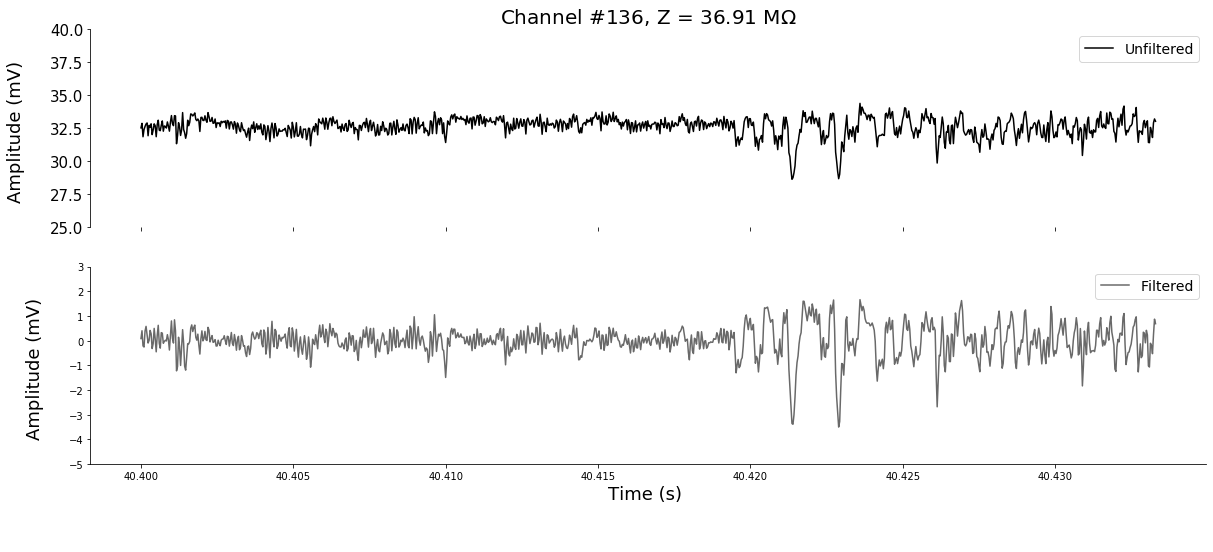

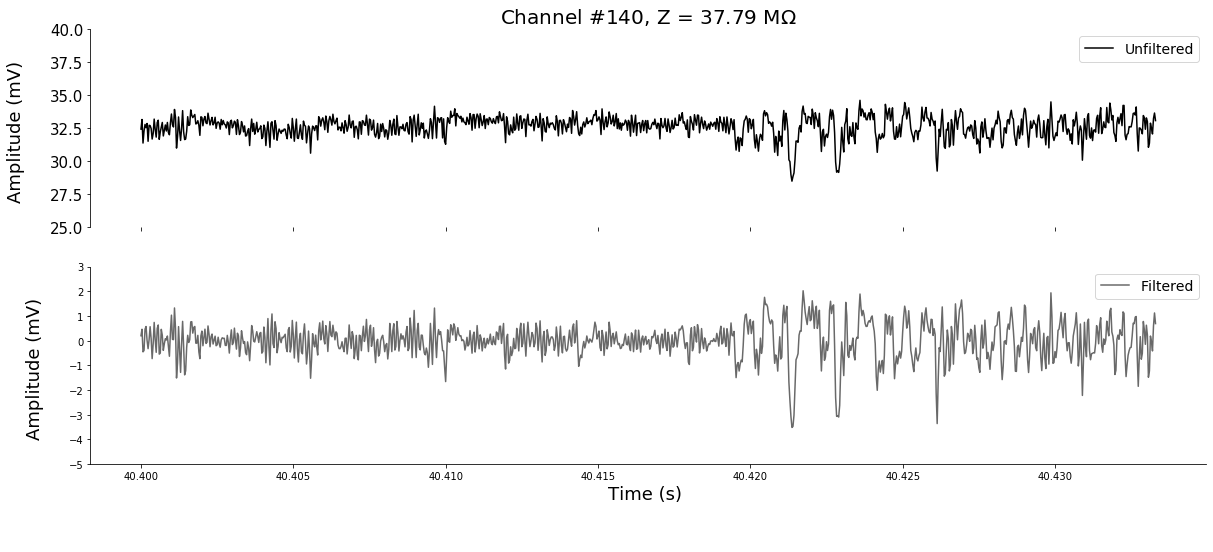

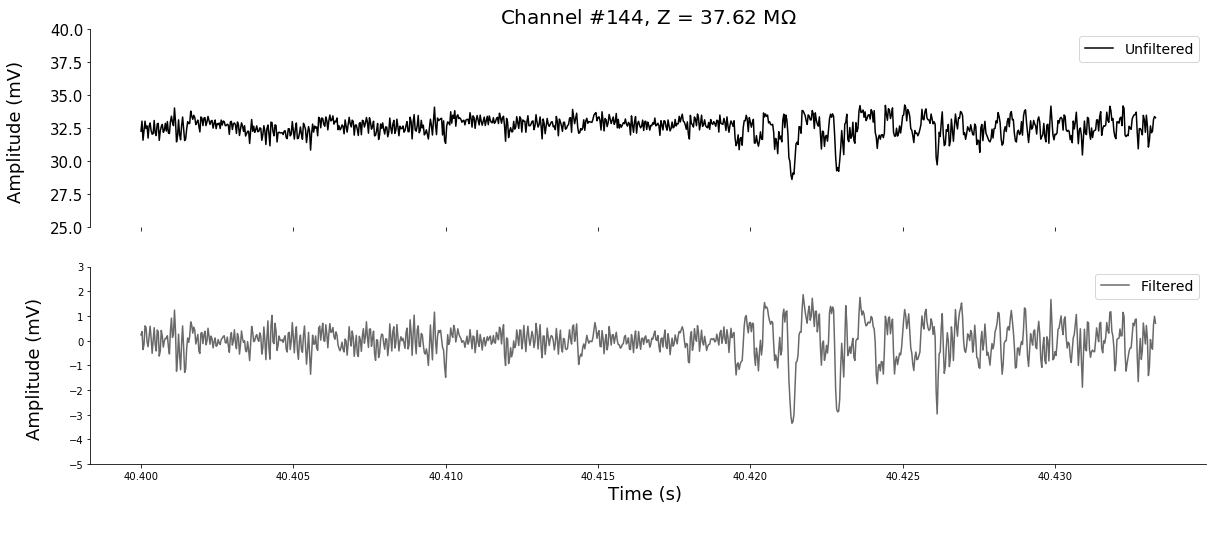

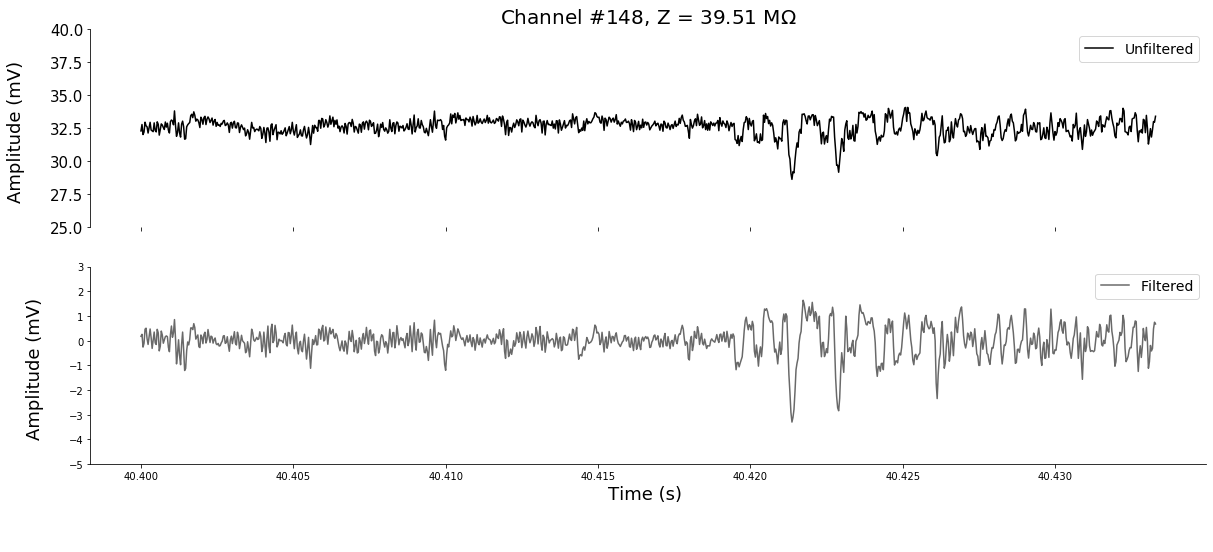

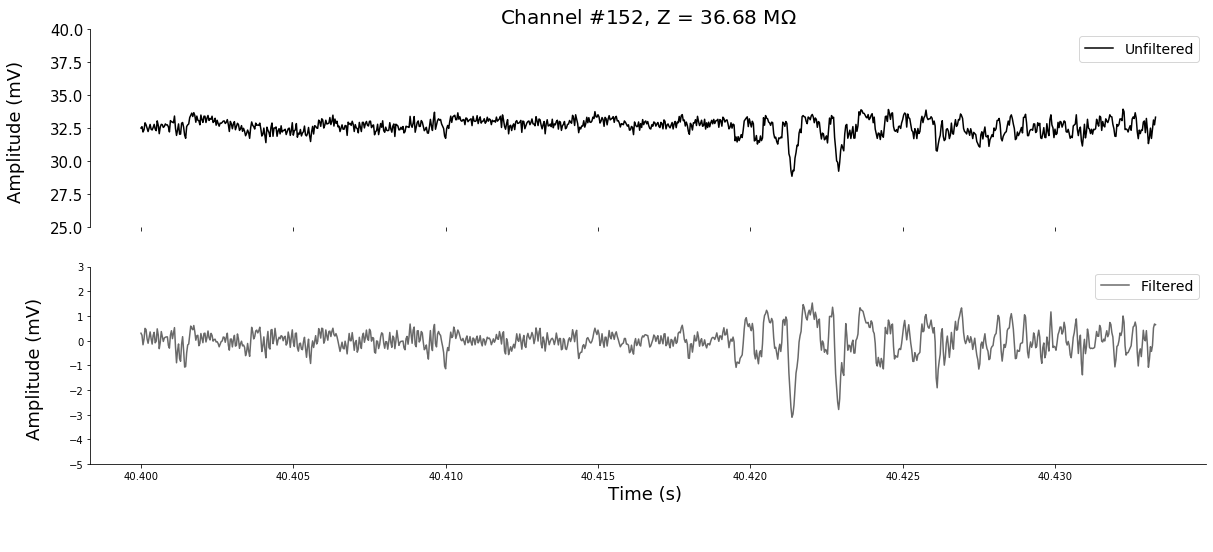

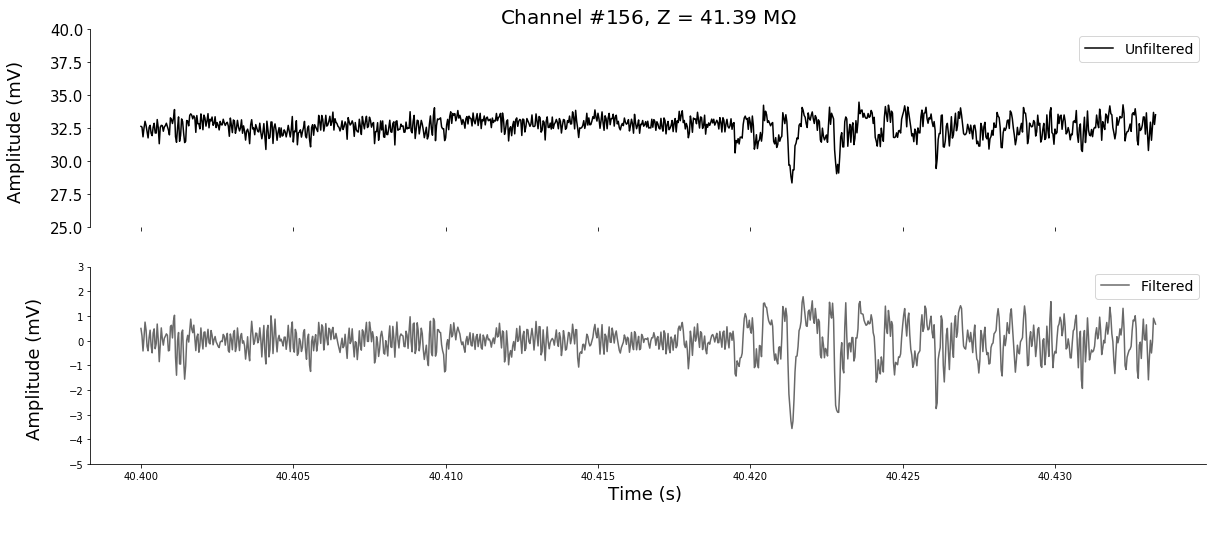

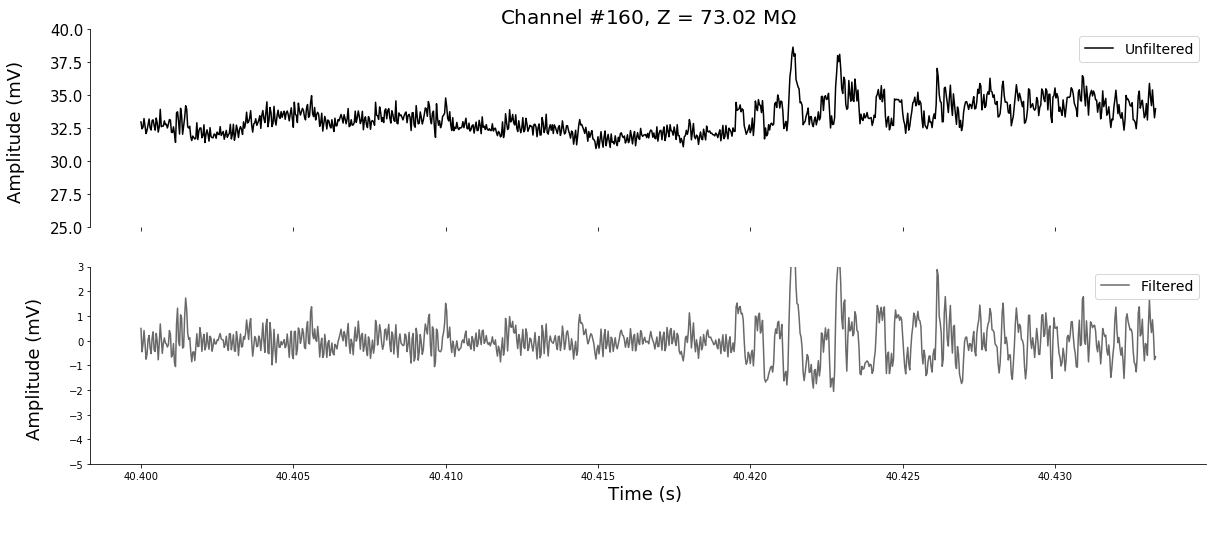

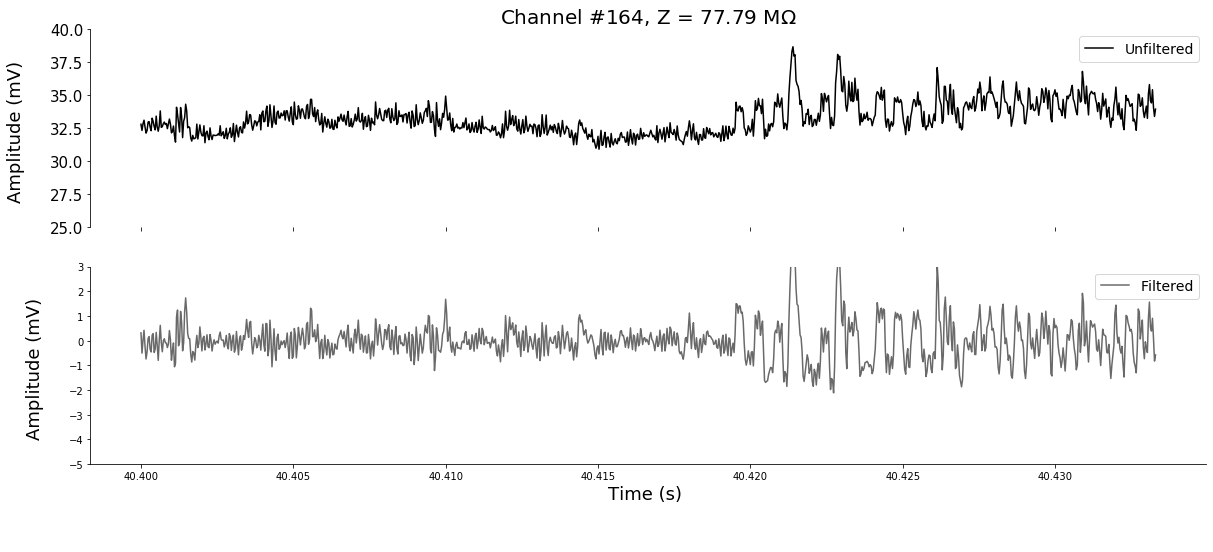

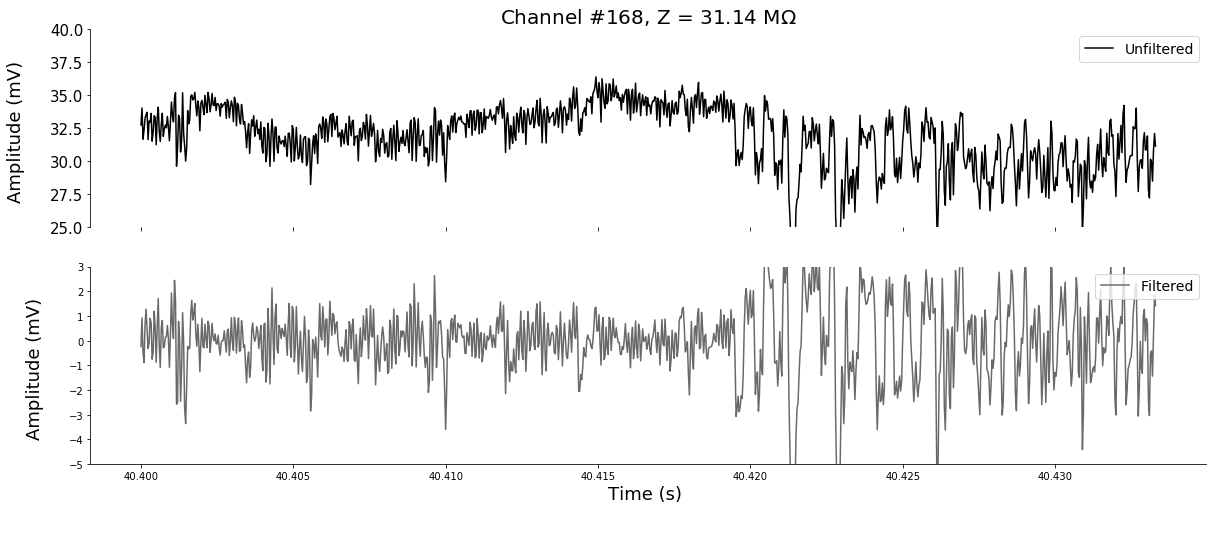

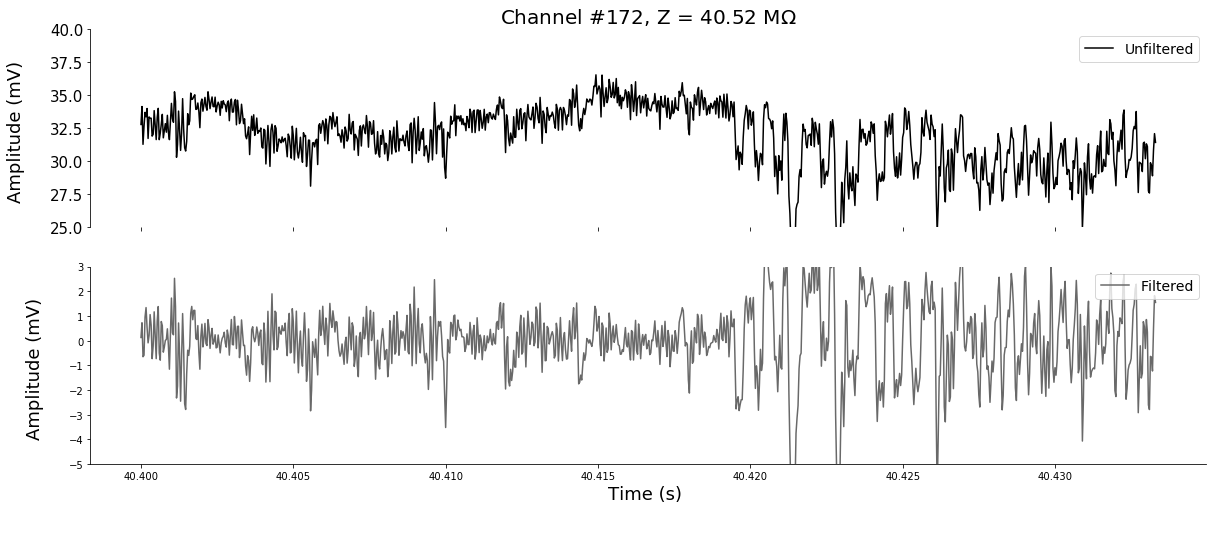

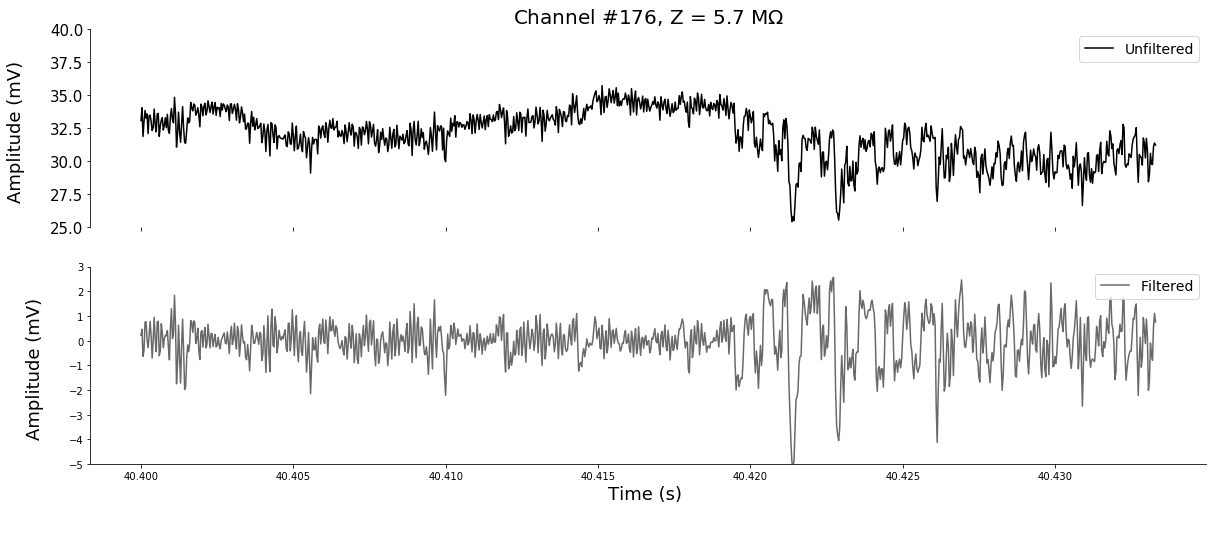

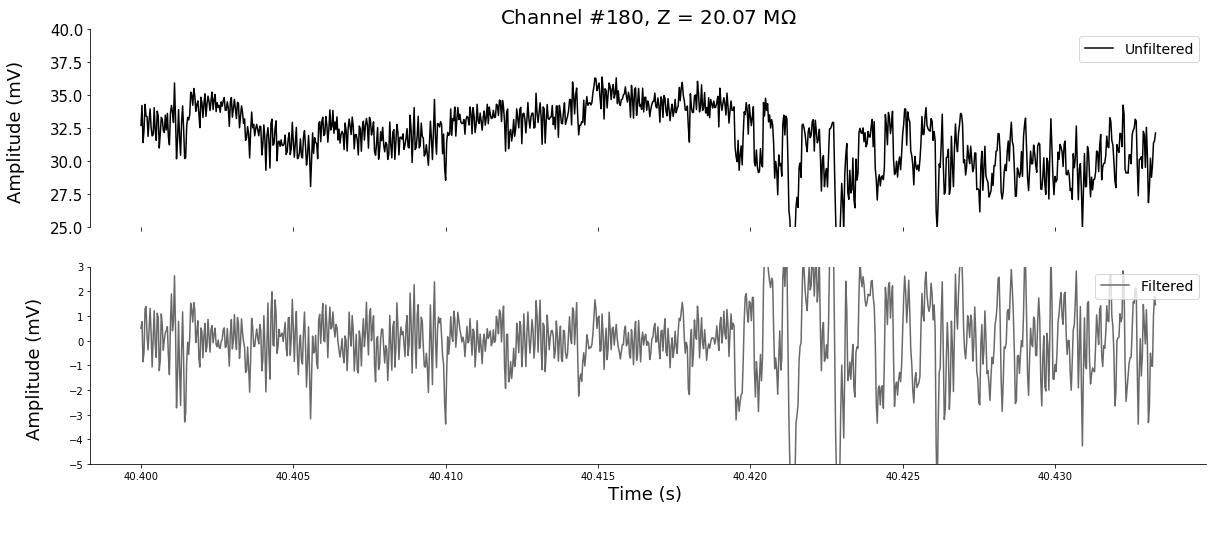

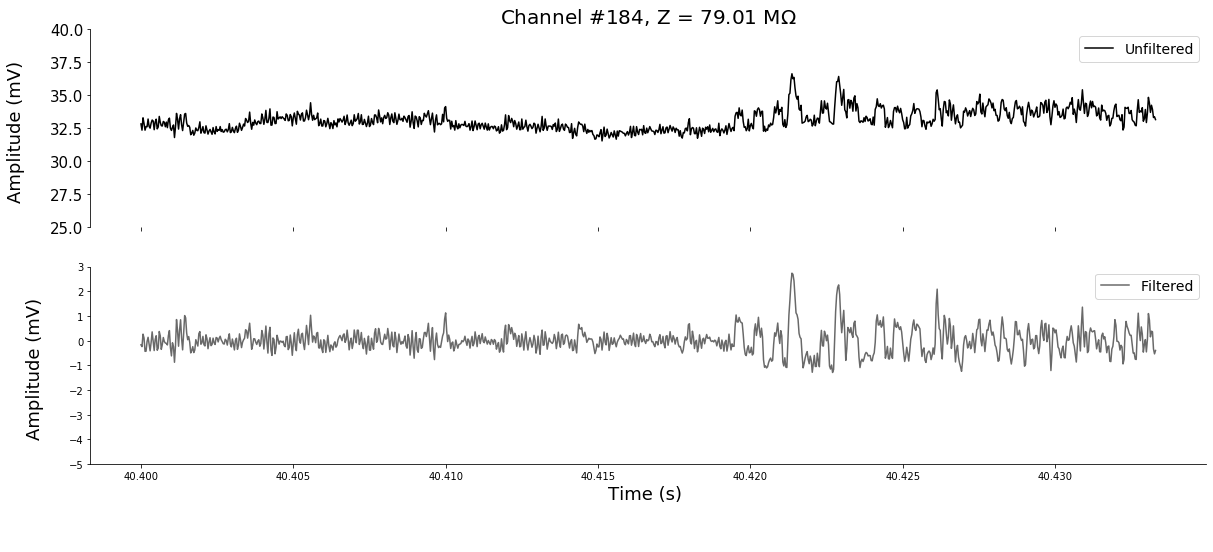

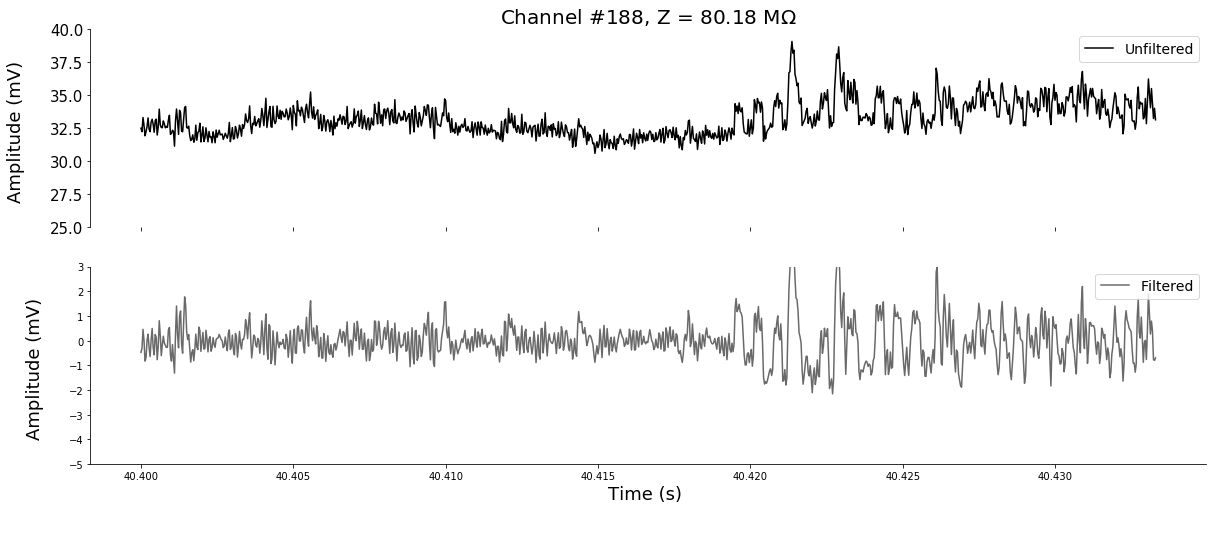

In [21]:
chans = list(np.arange(128,192,4))
start =1212000 
end = 1213000

display(HTML("<br><hr color = 'gray'><h2><br><center>Shank # 3, Plotting every 4th channel (128-192)</h2></center><br>"))
for chan in chans:
    
    fig, ax = plt.subplots (2,1, figsize = (20,8), sharex = True, frameon = True)

    ax[0].plot(x[start:end]/fs, ys[start:end, chan]/1000, color = "black", label='Unfiltered') # Unfiltered Signal
    ax[1].plot(x[start:end]/fs, y_filt[chan] [start:end]/1000, color = 'dimgray', label='Filtered') # Filtered Signal

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)

    y_lims = ax[0].get_ylim()
    ax[0].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[0].set_ylim(25, 40)
    y_lims = ax[1].get_ylim()
    #ax[1].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[1].set_ylim(-5, 3)
   
    ax[0].set_title("Channel #" + str(chan) + ', Z = ' + str(round(imp[chan],2))  + r' M$\Omega$', fontsize = 20)
    ax[1].set_xlabel('Time (s) \n \n', fontsize = 18)
    ax[0].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[1].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[0].tick_params (labelsize = 15)
    
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

plt.show()
    

## Plot Unfiltered and Filtered Traces from Shank #4

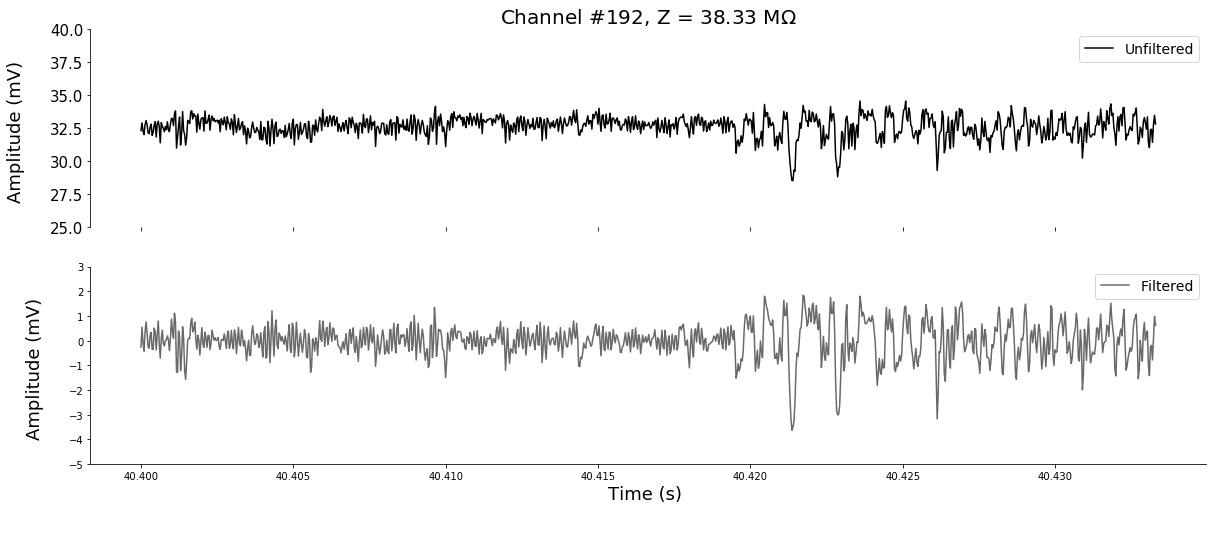

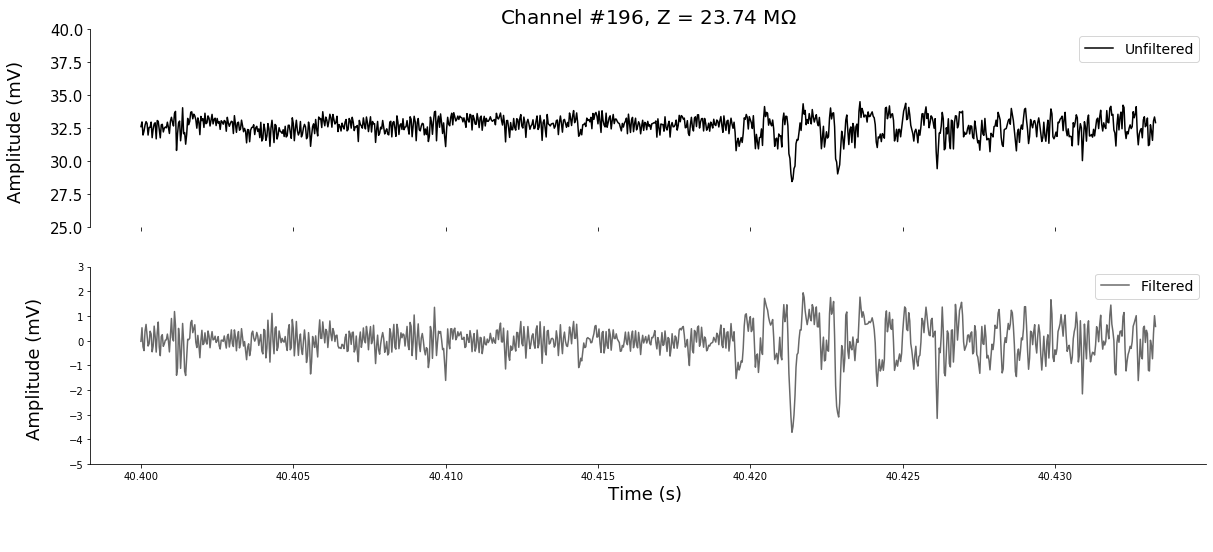

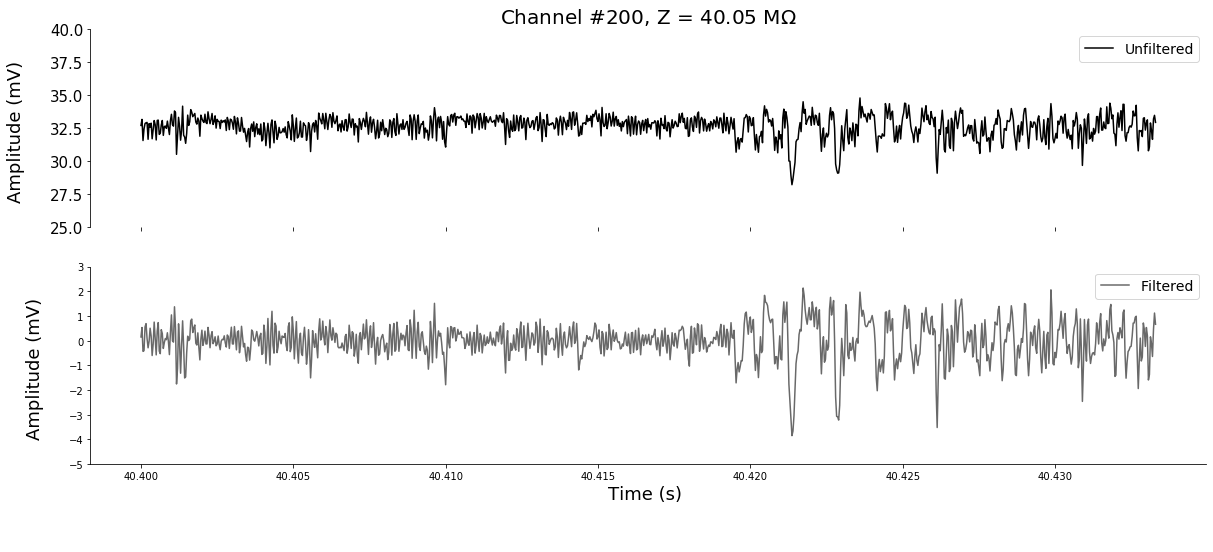

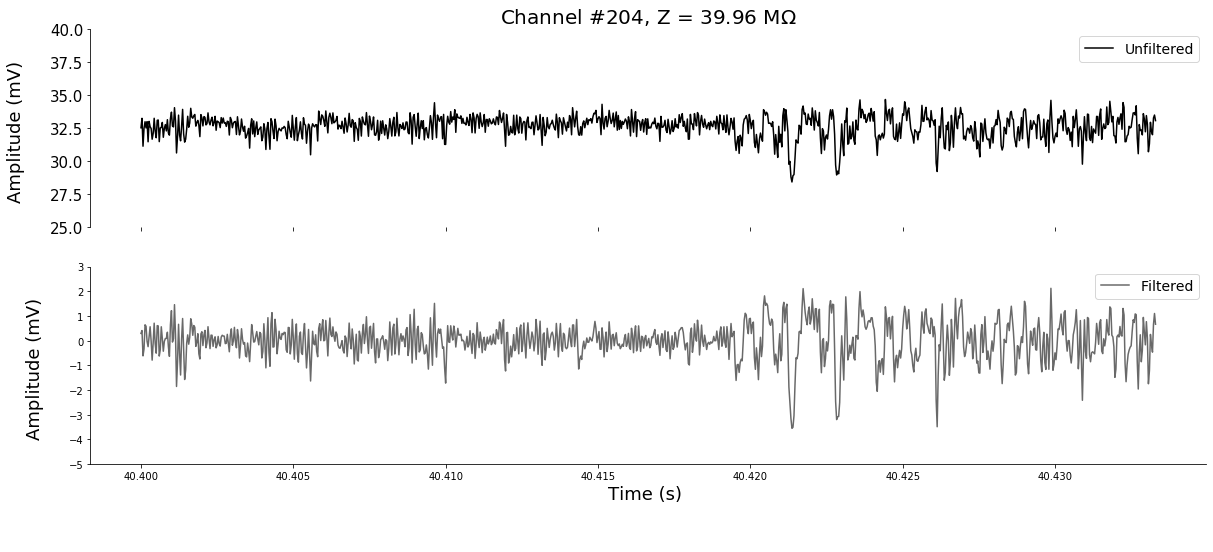

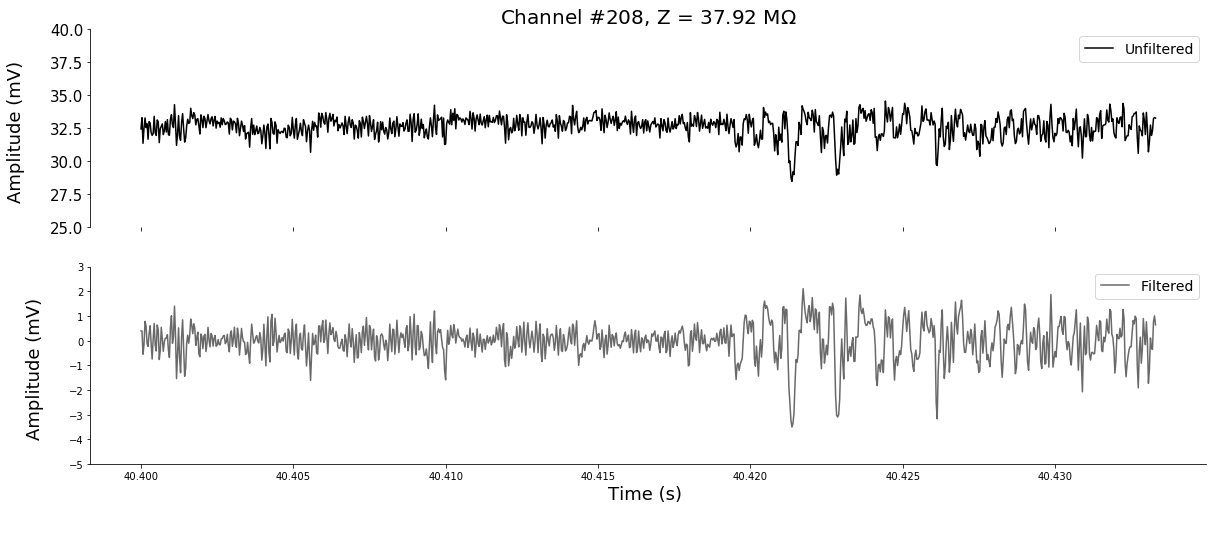

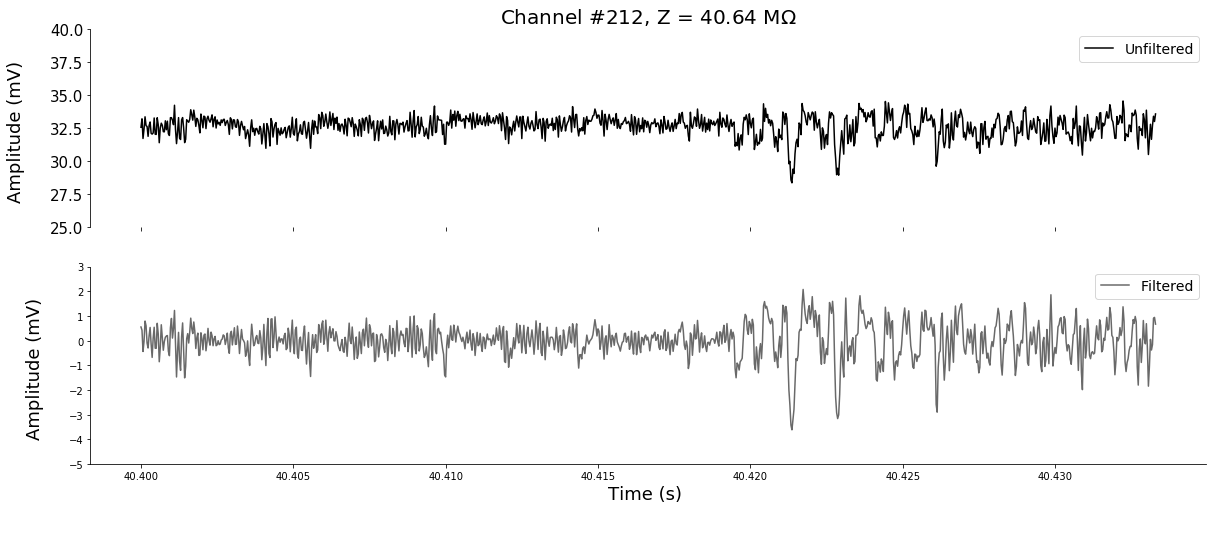

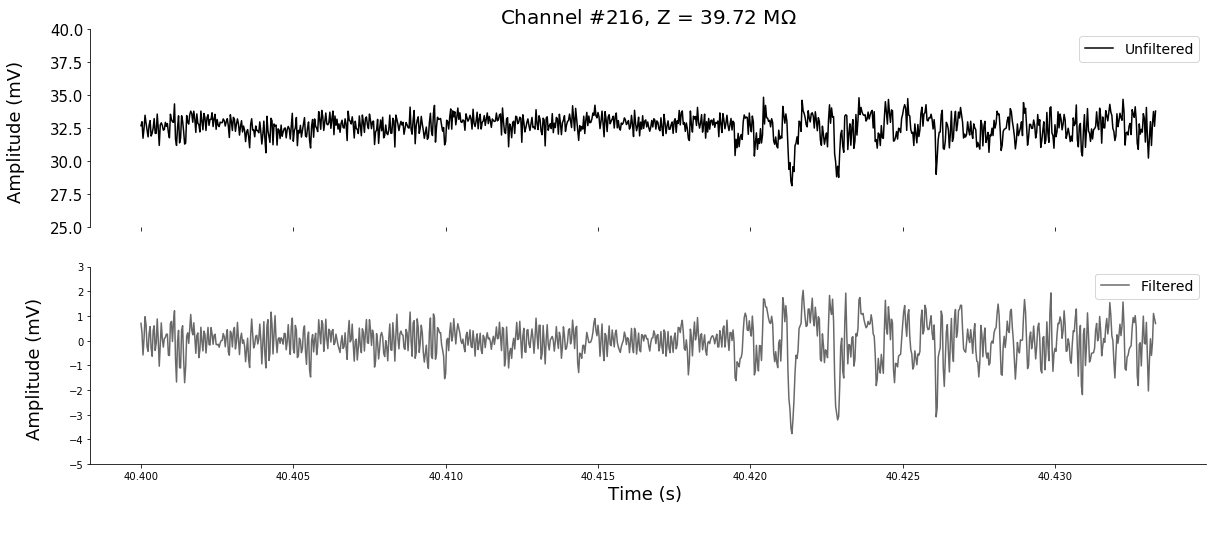

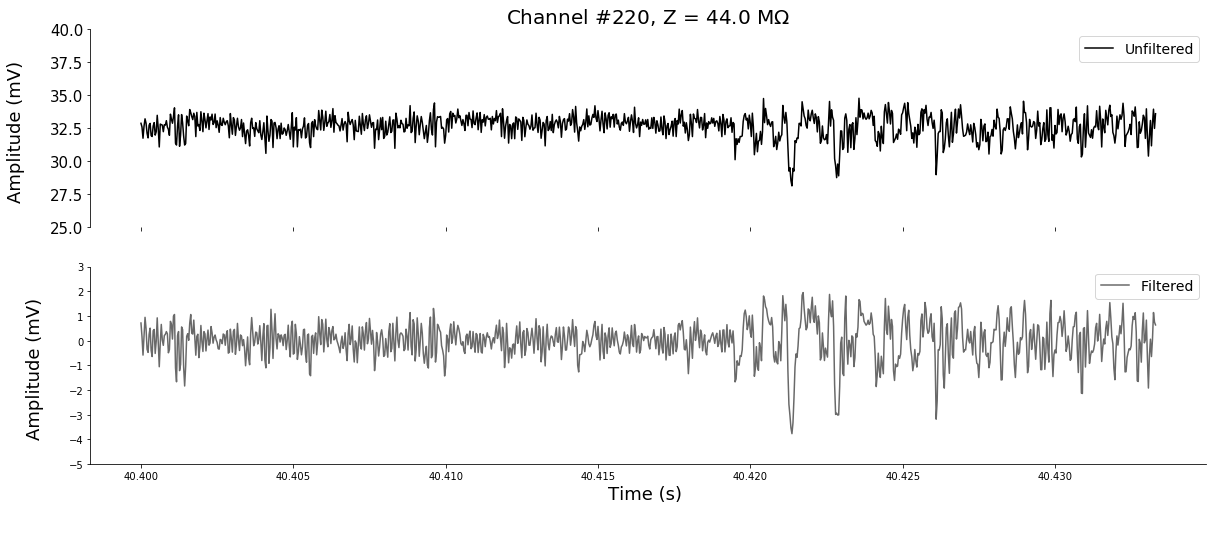

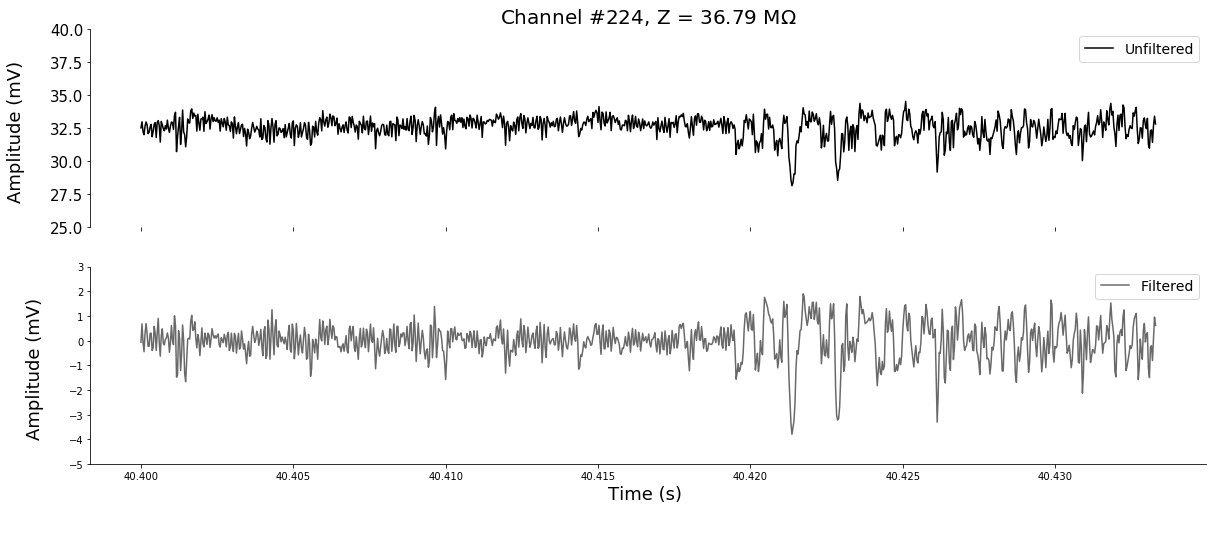

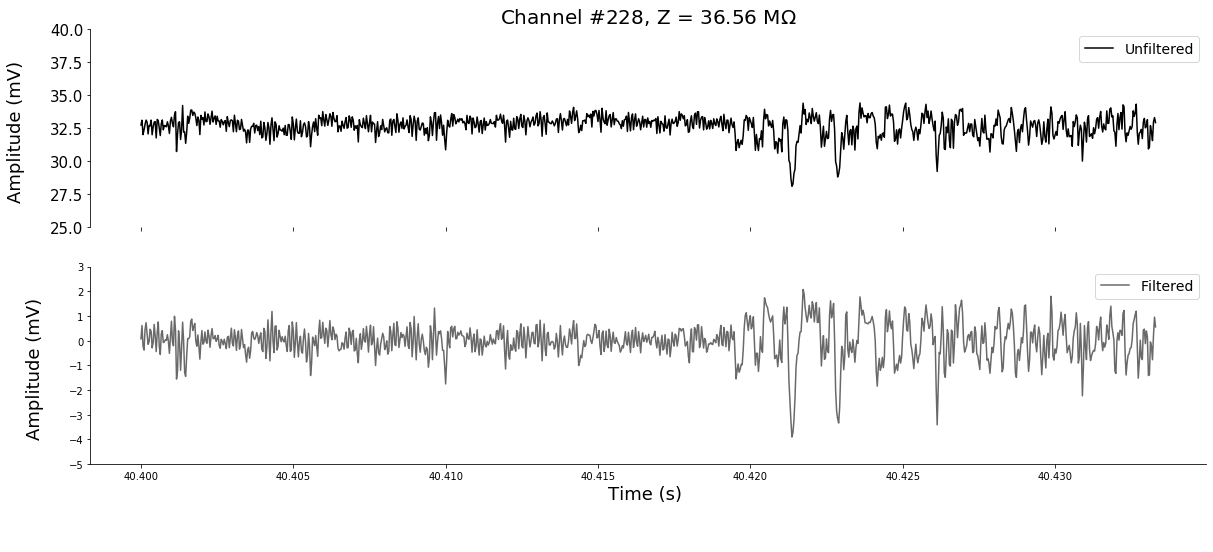

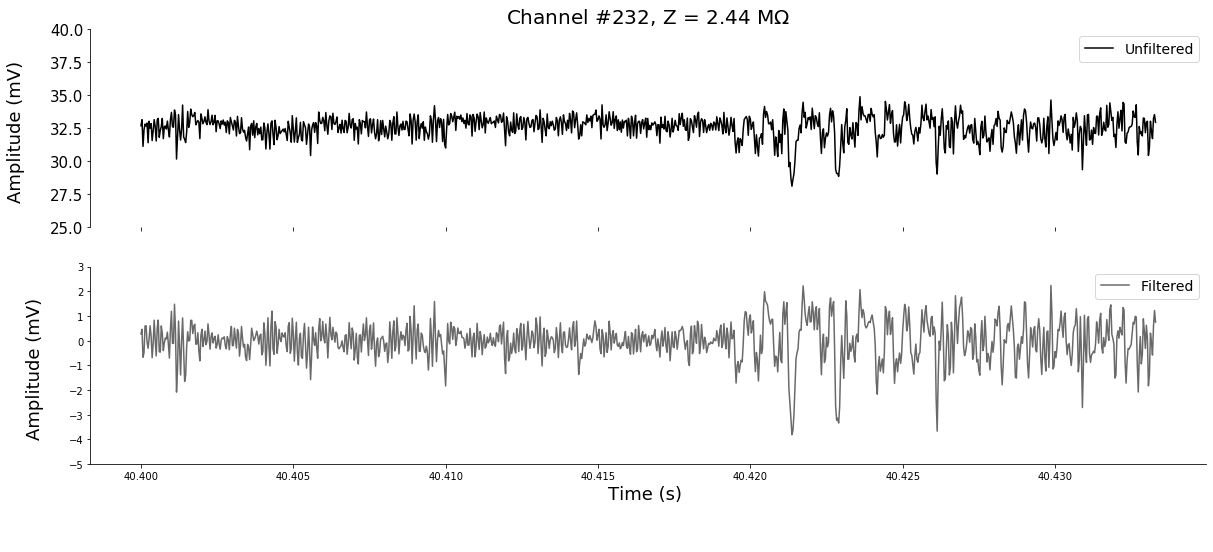

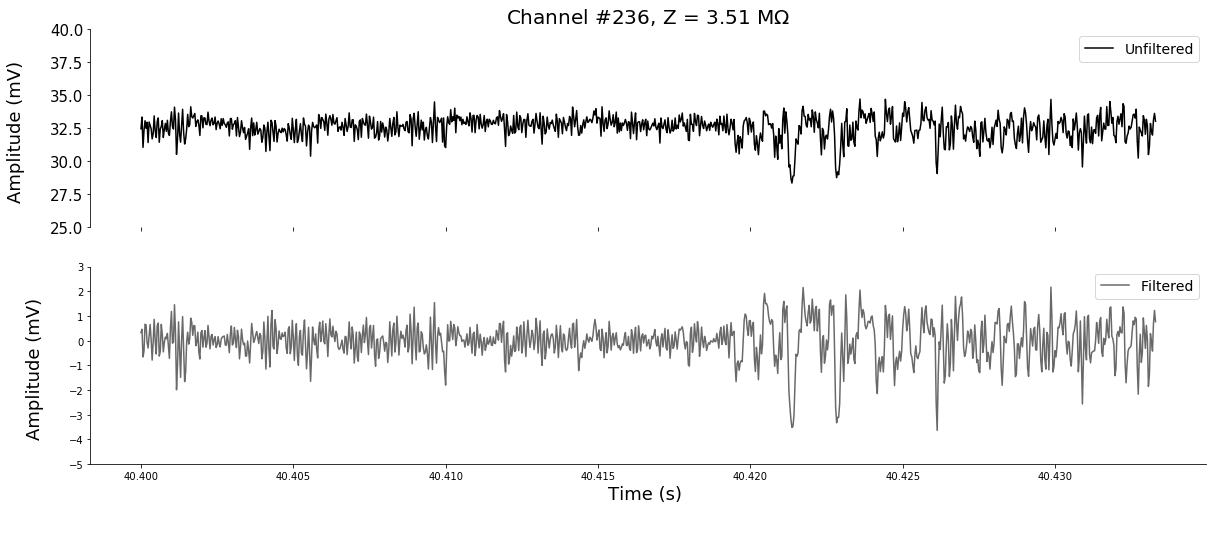

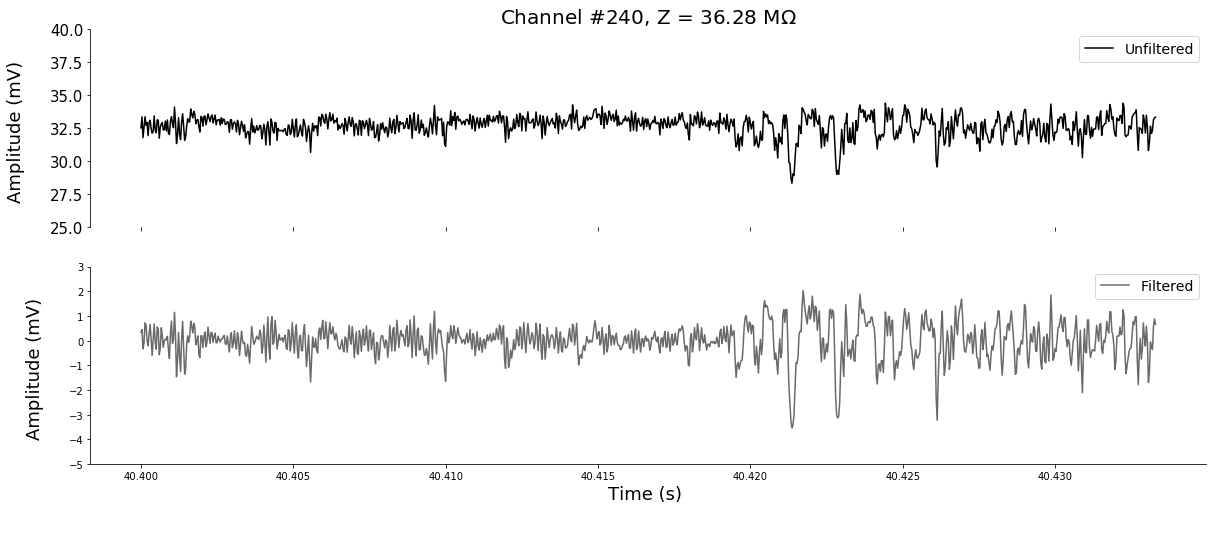

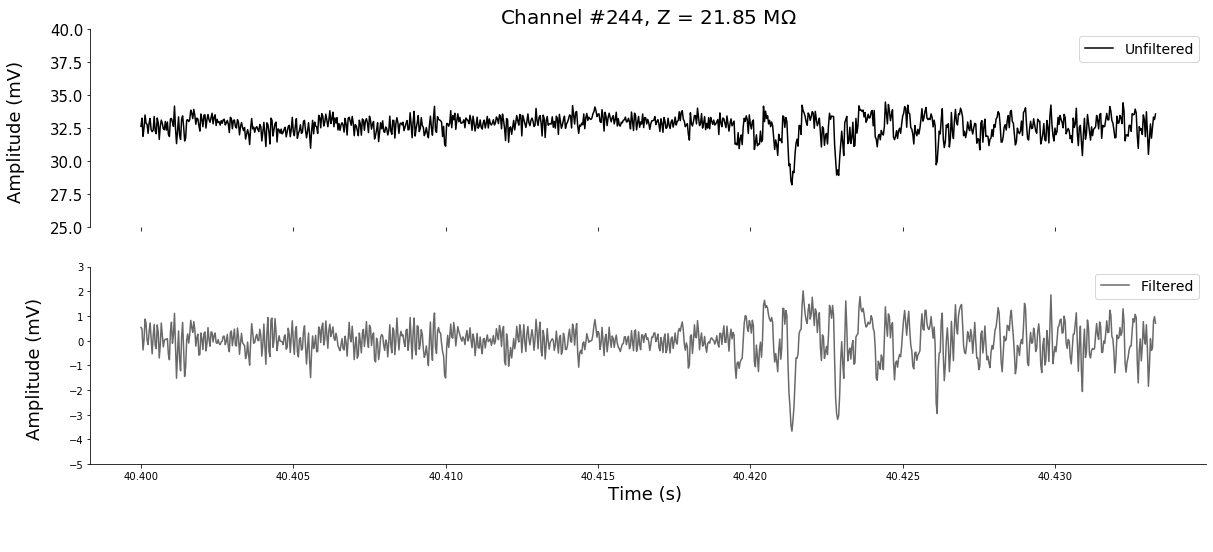

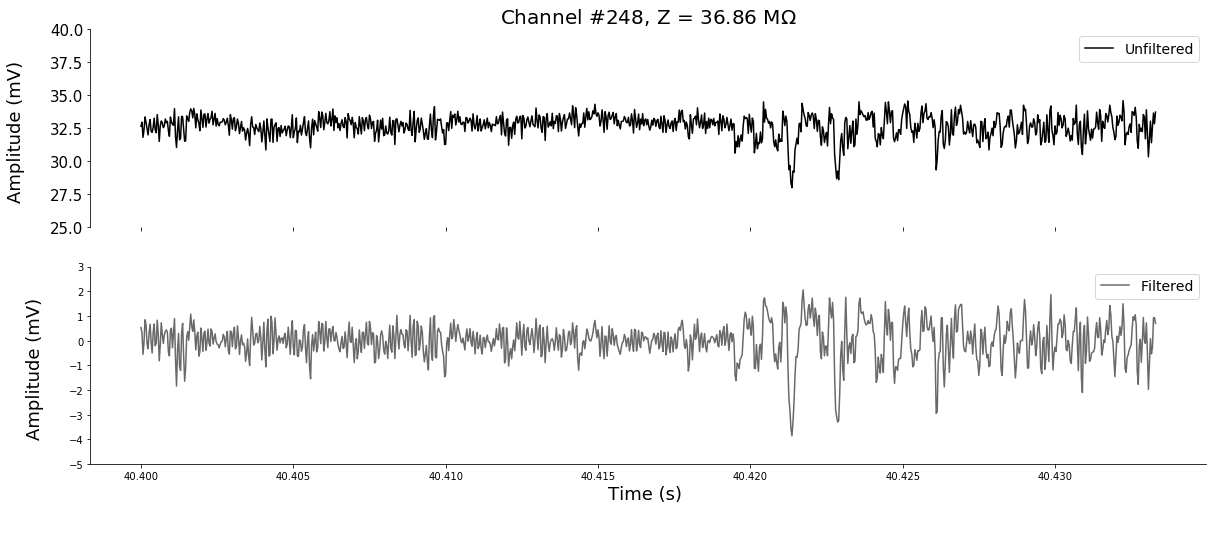

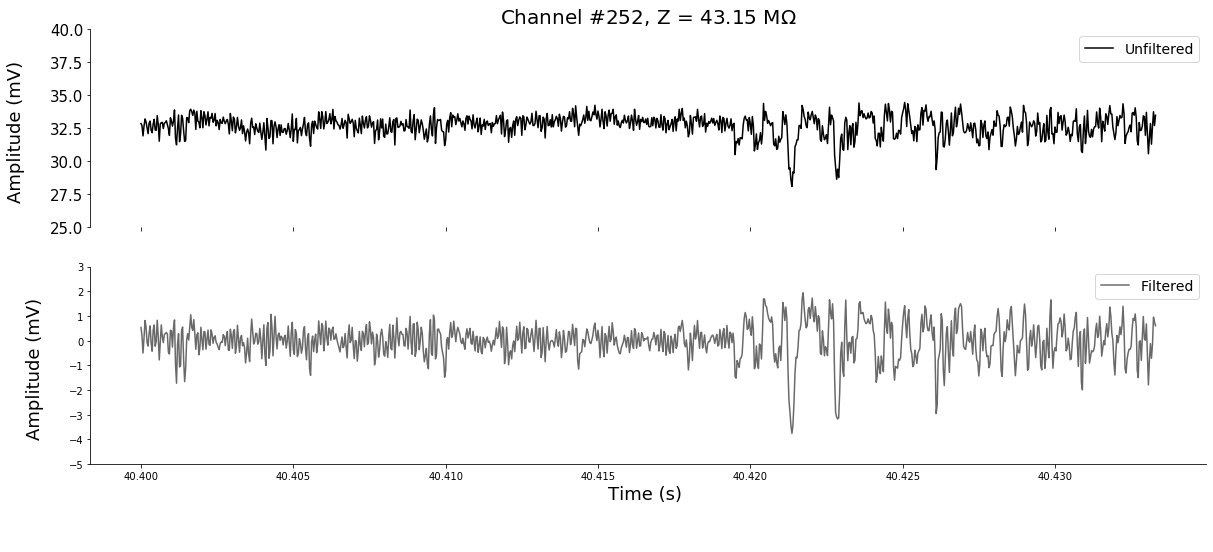

In [22]:
chans = list(np.arange(192,256,4))
start =1212000 
end = 1213000

display(HTML("<br><hr color = 'gray'><h2><br><center>Shank # 4, Plotting every 4th channel (192-256)</h2></center><br>"))
for chan in chans:
    
    fig, ax = plt.subplots (2,1, figsize = (20,8), sharex = True, frameon = True)

    ax[0].plot(x[start:end]/fs, ys[start:end, chan]/1000, color = "black", label='Unfiltered') # Unfiltered Signal
    ax[1].plot(x[start:end]/fs, y_filt[chan] [start:end]/1000, color = 'dimgray', label='Filtered') # Filtered Signal

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles, labels, loc = 'upper right', fontsize = 14, shadow = False)

    y_lims = ax[0].get_ylim()
    ax[0].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[0].set_ylim(25, 40)
    y_lims = ax[1].get_ylim()
    #ax[1].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
    ax[1].set_ylim(-5, 3)
   
    ax[0].set_title("Channel #" + str(chan) + ', Z = ' + str(round(imp[chan],2))  + r' M$\Omega$', fontsize = 20)
    ax[1].set_xlabel('Time (s) \n \n', fontsize = 18)
    ax[0].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[1].set_ylabel('Amplitude (mV) \n', fontsize = 18)
    ax[0].tick_params (labelsize = 15)
    
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

plt.show()
    